In [ ]:
#import libraries
!pip install fabio
!pip install pybaselines
import fabio
import math
import numpy as np
import matplotlib.pyplot as plt
from pybaselines.polynomial import modpoly
#from pybaselines.whittaker import imodpoly
from scipy.signal import savgol_filter
from scipy.optimize import minimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.3/199.3 kB 4.2 MB/s eta 0:00:00


In [ ]:
def view_cbf(file_path):
  try:
    #Load .cbf file
    image = fabio.open(file_path)

    #Print the data
    print("\nData: ")
    print(image.data)

    return image.data, image.data.shape[1], image.data.shape[0] #return dimensions/array

  #Exception case
  except Exception as e:
    print("Error:", e)
    return None, None, None

In [ ]:
#pixel to millimeter conversion
#MM_XFACTOR = 0.075
#MM_YFACTOR = -0.075
MM_XFACTOR = 0.75
MM_YFACTOR = -0.75
MM_YCONSTANT = 245
#conv_X = 0.075
DM_XFACTOR = 0.75
DM_YFACTOR = -0.75

In [ ]:
def find_center(dimensions):
  #Error case
  if dimensions is None:
    return None

  #Calculate center coordinates
  center_X = dimensions[0] // 2
  center_Y = dimensions[1] // 2

  # Ajust from image center to circle center (00004)
  center_X = center_X + 16
  center_Y = center_Y - 8
  # Ajust from image center to circle center (00026)
  # center_X = center_X + 16
  # center_Y = center_Y - 7
  print(f'center_X: {center_X}, center_Y: {center_Y}')

  return (center_X, center_Y)

In [ ]:
def calculate_distance_and_intensity(image_data, width, height):
    results = []

    #center to find dist
    center_x, center_y = find_center((width, height))

    #intensity: array values of loaded .cbf, distance: sqrt(x^2 + y^2)
    for x in range(width):
        for y in range(height):
            intensity = image_data[y, x]  # Note: FabIO uses (y, x) indexing
            # distance = round(math.sqrt((center_x - x) ** 2 + (center_y - y) ** 2))
            distance = round(math.sqrt(((center_x - x)*MM_XFACTOR) ** 2 + ((center_y - y)*MM_YFACTOR) ** 2))
            results.append((x, y, intensity, distance))

    print(f'results size: {len(results)}')

    return results

In [ ]:
#for verification after replacement of negligible values
def has_negative_values(image_data):
  return np.any(image_data == 0)

In [ ]:
def replace_negative_values(image_data):
  #Find base data
  height, width = image_data.shape
  center_x, center_y = find_center((width, height))

  #Create arrays to store distances
  y_index, x_index = np.indices(image_data.shape)
  distances = np.round(np.sqrt((x_index - center_x) ** 2 + (y_index - center_y) ** 2)).astype(int)

  #Dictionaries
  distance_sums = {}
  distance_counts = {}

  #Iterate through each pixel, and obtain each distance value
  for y in range(height):
    for x in range(width):
      dist = distances[y, x]
      pixel_value = image_data[y, x]
      if pixel_value not in (0, -1):
        if dist in distance_sums:
          distance_sums[dist] += pixel_value
          distance_counts[dist] += 1
        else:
          distance_sums[dist] = pixel_value
          distance_counts[dist] = 1

  #Compute average for each distance
  distance_averages = {dist: distance_sums[dist] / distance_counts[dist] for dist in distance_sums}

  #Replace pixel values with average distance values
  new_image_data = np.copy(image_data)
  for y in range(height):
    for x in range(width):
      dist = distances[y, x]
      if new_image_data[y, x] in (0, -1):
        new_image_data[y, x] = distance_averages.get(dist, -1) #Default to -1 still if no average is found
      if new_image_data[y, x] < -1:
        #print(f'Top-Left: Distance: {distances[i]:.2f}, Intensity: {intensities[i]}')
        new_image_data[y, x] = 0 #Default to 0 still if image data is < -1 (due to background substraction)

  return new_image_data

tisaodif



In [ ]:
def objective_function(c, points):
    cx, cy = c
    distances = [np.sqrt((cx - x)**2 + (cy - y)**2) for x, y in points]
    avg_distance = np.mean(distances)
    return sum((d - avg_distance)**2 for d in distances)

In [ ]:
def circle_center(x1, y1, x2, y2, x3, y3, ix, iy, width, height):
    points = [(x1, y1), (x2, y2), (x3, y3)]
    image_center = np.array([ix, iy])

    # Bounds for cx, cy to be within 50 pixels of the image center
    bounds = ((ix - 50, ix + 50), (iy - 50, iy + 50))

    # Initial guess: Use the image center as the initial guess for simplicity
    initial_guess = image_center

    # Perform the minimization
    result = minimize(objective_function, initial_guess, args=(points,), bounds=bounds)

    if result.success:
        return result.x
    else:
        raise ValueError("Optimization failed:", result.message)

In [ ]:
def calculate_trig_expression(x):
    # Calculate arctan(x / 135)
    #arctan_result = math.atan(x / 135)
    arctan_result = math.atan(x / 1350)

    # Convert arctan result from radians to degrees
    arctan_degrees = math.degrees(arctan_result)

    # Subtract from 180 degrees (do not substract anymore)
    result = arctan_degrees

    return result

In [ ]:
def calculate_twotheta_conversion(twotheta):
    # Convert twotheta to theta in degrees
    theta = twotheta / 2

    # Convert theta from degrees to radians
    theta_radians = math.radians(theta)

    # Calculate sin(theta)
    sin_theta = math.sin(theta_radians)

    # Calculate 1.54 * sin(theta)
    argument = 1.54 * sin_theta

    # Check if the argument is within the domain of arcsin function
    if abs(argument) > 1:
        print("Error: arcsin argument out of bounds")
        return None  # Or handle the error as needed

    # Calculate arcsin(1.54 * sin(theta))
    arcsin_value = math.asin(argument)

    # Calculate the final result
    result = 2 * math.degrees(arcsin_value)  # Convert the result back to degrees

    return result

In [ ]:
def calculate_sum_of_intensity(results, width, height):
    max_distance = round(math.sqrt(((width / 2) * MM_XFACTOR) ** 2 + ((height / 2) * MM_YFACTOR) ** 2))  # Calculate the maximum distance in MM
    print(f'max_distance size: {max_distance}')

    sumOfIntensity = np.zeros(int(max_distance + 15))  # Create an array to store sum of intensities in MM
    countOfIntensity = np.zeros(int(max_distance + 15))  # Create an array to count intensities in MM
    averageOfIntensity = np.zeros(int(max_distance + 15))  # Create an array to store average of intensities in MM

    for result in results:
        distance = result[3]
        intensity = result[2]
        sumOfIntensity[distance] += intensity  # Add intensity to the corresponding distance in sumOfIntensity
        countOfIntensity[distance] += 1  # Count the number of pixels contributing to this distance

    for distance in range(max_distance + 1):
        if countOfIntensity[distance] > 0:
            averageOfIntensity[distance] = sumOfIntensity[distance] / countOfIntensity[distance]  # Calculate the average intensity

    distance = int((width / 2) * MM_XFACTOR)-1;
    for distance in range(int((width / 2) * MM_XFACTOR), max_distance + 1):
        # print(f"Distance: {distance}, Average Intensity: {averageOfIntensity[distance]}, Sum Before: {sumOfIntensity[distance]}")
        sumOfIntensity[distance] = averageOfIntensity[distance] * ((distance / MM_XFACTOR) * 2 * math.pi / MM_XFACTOR)
        # print(f"Sum After: {sumOfIntensity[distance]}")

    return sumOfIntensity

In [ ]:
def calculate_sum_of_intensity_with_twotheta_distances(results, width, height, convert):
    max_distance = round(math.sqrt(((width / 2) * MM_XFACTOR) ** 2 + ((height / 2) * MM_YFACTOR) ** 2))  # Calculate the maximum distance in MM
    max_twotheta_distance = round(calculate_trig_expression(max_distance))

    # max is 180 because result = 180 - arctan_degrees
    # sumOfIntensitytwotheta = np.zeros(182)  # Create an array to store sum of intensities in MM
    # countOfIntensitytwotheta = np.zeros(182)  # Create an array to count intensities in MM
    # averageOfIntensitytwotheta = np.zeros(182)  # Create an array to store average of intensities in MM
    summed_intensity = {}
    count_intensity = {}

    for result in results:
        distance = result[3]
        intensity = result[2]
        #twotheta_distance = round(calculate_trig_expression(distance))
        twotheta_distance = calculate_trig_expression(distance)
        if (convert):
          twotheta_distance = calculate_twotheta_conversion(twotheta_distance)
        if twotheta_distance in summed_intensity:
          summed_intensity[twotheta_distance] += intensity
          count_intensity[twotheta_distance] += 1
        else:
          summed_intensity[twotheta_distance] = intensity
          count_intensity[twotheta_distance] = 1

    #for twotheta_distance in range(max_twotheta_distance + 1):
    #    if countOfIntensitytwotheta[twotheta_distance] > 0:
    #        averageOfIntensitytwotheta[twotheta_distance] = sumOfIntensitytwotheta[twotheta_distance] / countOfIntensitytwotheta[twotheta_distance]  # Calculate the average intensity

    #twotheta_distance = int(calculate_trig_expression((width / 2) * MM_XFACTOR))-1;
    # print(f"Distance: {distance}, Average Intensity: {averageOfIntensity[distance]}, Sum way before: {sumOfIntensity[distance]}")
    #for twotheta_distance in range(int(calculate_trig_expression((width / 2) * MM_XFACTOR)), max_distance + 1):
        # print(f"Distance: {distance}, Average Intensity: {averageOfIntensity[distance]}, Sum Before: {sumOfIntensity[distance]}")
    #    sumOfIntensitytwotheta[twotheta_distance] = averageOfIntensitytwotheta[twotheta_distance] * ((twotheta_distance / MM_XFACTOR) * 2 * math.pi / MM_XFACTOR)
        # print(f"Sum After: {sumOfIntensity[distance]}")

    return summed_intensity

In [ ]:
def plot_intensity_values(sumOfIntensity, title):
    plt.plot(sumOfIntensity)
    plt.title(title)
    plt.xlabel('Distance')
    plt.ylabel('Intensity')
    plt.show()

In [ ]:
def plot_vertical_line_intensity(image_data, center_x, center_y, title):
  #Plot from center to top
  vert_line_intensity_top = image_data[:center_y, center_x]
  plt.plot(range(center_y, center_y - len(vert_line_intensity_top), -1), vert_line_intensity_top, label = 'Center to top')

  #Plot from center to bottom
  vert_line_intensity_bottom = image_data[center_y:, center_x]
  plt.plot(range(center_y, center_y + len(vert_line_intensity_bottom)), vert_line_intensity_bottom, label='Center to bottom')

  #Draw
  plt.title(title)
  plt.xlabel('Pixel Index')
  plt.ylabel("Intensity")
  plt.legend()
  plt.show()


In [ ]:
def plot_diagonal_intensity(image_data, center_x, center_y, title):
    # Working algorithm, but it's absolete
    height, width = image_data.shape

    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes = axes.flatten()

    # Diagonal from center to top-left
    top_left_intensity = []
    for i in range(min(center_x, center_y)):
        y = center_y - i
        x = center_x - i
        if y >= 0 and x >= 0:
            distance = i * np.sqrt(2)
            intensity = image_data[y, x]
            top_left_intensity.append(intensity)
            #if (i>600 and i<750):
            #print(f'Top-Left: Distance: {distance:.2f}, Intensity: {intensity}')

    axes[0].plot([i * np.sqrt(2) for i in range(len(top_left_intensity))], top_left_intensity)
    axes[0].set_title('Center to Top-Left')
    axes[0].set_xlabel('Distance')
    axes[0].set_ylabel('Intensity')

    # Diagonal from center to top-right
    top_right_intensity = []
    for i in range(min(center_y, width - center_x)):
        y = center_y - i
        x = center_x + i
        if y >= 0 and x < width:
            distance = i * np.sqrt(2)
            intensity = image_data[y, x]
            top_right_intensity.append(intensity)
            #if (i>600 and i<750):
            #print(f'Top-Right: Distance: {distance:.2f}, Intensity: {intensity}')

    axes[1].plot([i * np.sqrt(2) for i in range(len(top_right_intensity))], top_right_intensity)
    axes[1].set_title('Center to Top-Right')
    axes[1].set_xlabel('Distance')
    axes[1].set_ylabel('Intensity')

    # Diagonal from center to bottom-left
    bottom_left_intensity = []
    for i in range(min(center_x, height - center_y)):
        y = center_y + i
        x = center_x - i
        if y < height and x >= 0:
            distance = i * np.sqrt(2)
            intensity = image_data[y, x]
            bottom_left_intensity.append(intensity)
            #if (i>600 and i<750):
            #  print(f'Bottom-Left: Distance: {distance:.2f}, Intensity: {intensity}')

    axes[2].plot([i * np.sqrt(2) for i in range(len(bottom_left_intensity))], bottom_left_intensity)
    axes[2].set_title('Center to Bottom-Left')
    axes[2].set_xlabel('Distance')
    axes[2].set_ylabel('Intensity')

    # Diagonal from center to bottom-right
    bottom_right_intensity = []
    for i in range(min(width - center_x, height - center_y)):
        y = center_y + i
        x = center_x + i
        if y < height and x < width:
            distance = i * np.sqrt(2)
            intensity = image_data[y, x]
            bottom_right_intensity.append(intensity)
            #if (i>600 and i<750):
            #  print(f'Bottom-Right: Distance: {distance:.2f}, Intensity: {intensity}')

    axes[3].plot([i * np.sqrt(2) for i in range(len(bottom_right_intensity))], bottom_right_intensity)
    axes[3].set_title('Center to Bottom-Right')
    axes[3].set_xlabel('Distance')
    axes[3].set_ylabel('Intensity')

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_additional_diagonal_intensity(image_data, center_x, center_y, title):
    # Working algorithm, but it's absolete
    height, width = image_data.shape

    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes = axes.flatten()

    # Add 4 additional diagonal lines
    # Diagonal from center to middle-top-left
    middle_top_left_intensity = [image_data[int(center_y - i / 2), int(center_x - i)] for i in range(min(center_x, center_y)) if center_y - i / 2 >= 0 and center_x - i >= 0]
    axes[0].plot(range(len(middle_top_left_intensity)), middle_top_left_intensity)
    axes[0].set_title('Center to Middle-Top-Left')
    axes[0].set_xlabel('Distance')
    axes[0].set_ylabel('Intensity')

    # Diagonal from center to middle-top-right
    middle_top_right_intensity = [image_data[int(center_y - i / 2), int(center_x + i)] for i in range(min(center_x, center_y, width - center_x)) if center_y - i / 2 >= 0 and center_x + i < width]
    axes[1].plot(range(len(middle_top_right_intensity)), middle_top_right_intensity)
    axes[1].set_title('Center to Middle-Top-Right')
    axes[1].set_xlabel('Distance')
    axes[1].set_ylabel('Intensity')

    # Diagonal from center to middle-bottom-left
    middle_bottom_left_intensity = [image_data[int(center_y + i / 2), int(center_x - i)] for i in range(min(center_x, height - center_y)) if int(center_y + i / 2) < height and int(center_x - i) >= 0]
    axes[2].plot(range(len(middle_bottom_left_intensity)), middle_bottom_left_intensity)
    axes[2].set_title('Center to Middle-Bottom-Left')
    axes[2].set_xlabel('Distance')
    axes[2].set_ylabel('Intensity')

    # Diagonal from center to middle-bottom-right
    middle_bottom_right_intensity = [image_data[int(center_y + i / 2), int(center_x + i)] for i in range(min(center_x, center_y, width - center_x, height - center_y)) if int(center_y + i / 2) < height and int(center_x + i) < width]
    axes[3].plot(range(len(middle_bottom_right_intensity)), middle_bottom_right_intensity)
    axes[3].set_title('Center to Middle-Bottom-Right')
    axes[3].set_xlabel('Distance')
    axes[3].set_ylabel('Intensity')

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

In [ ]:
def find_intensity_values(image_data, threshold=100000):
  height, width = image_data.shape
  high_intensity_values = []

  for y in range(height):
    for x in range(width):
      if image_data[y, x] > threshold:
        high_intensity_values.append((x, y, image_data[y, x]))

  return high_intensity_values

In [ ]:
def plot_grayscale_image(image_data):
  plt.imshow(image_data, cmap='gray_r', origin='upper', vmin=0, vmax=5000)
  plt.colorbar()
  plt.title('Grayscale Image of CBF Data')
  plt.show()

In [ ]:
def plot_combined_diagonal_intensity(image_data, center_x, center_y, title):
    # Working algorithm (latest)
    height, width = image_data.shape

    # Initialize dictionaries to hold summed intensities and counts
    summed_intensity = {}
    counts = {}

    def find_components(distance, angle_degrees):
      # Convert angle to radians
      angle_radians = math.radians(angle_degrees)

      # Calculate x and y components
      x_component = distance * math.cos(angle_radians)
      y_component = distance * math.sin(angle_radians)

      return x_component, y_component

    def add_to_sums(distances, intensities):
        for dist, intensity in zip(distances, intensities):
            if dist in summed_intensity:
                summed_intensity[dist] += intensity
                counts[dist] += 1
            else:
                summed_intensity[dist] = intensity
                counts[dist] = 1

    # Function to collect distances and intensities for a line
    def get_intensity_along_line(y_values, x_values):
        distances = np.sqrt((np.array(y_values) - center_y)**2 + (np.array(x_values) - center_x)**2)
        intensities = [image_data[y, x] for y, x in zip(y_values, x_values)]
        return distances, intensities

    # Diagonal from center to top-left
    y_values = [center_y - i for i in range(min(center_x, center_y))]
    x_values = [center_x - i for i in range(min(center_x, center_y))]
    distances, intensities = get_intensity_along_line(y_values, x_values)
    #add_to_sums(distances * np.sqrt(2), intensities)  # Adjust distances for 45-degree diagonal
    add_to_sums(distances, intensities)  # Adjust distances for 45-degree diagonal
    # for i in range(len(distances)):
    #   if (i>150 and i<350):
    #     print(f'Top-Left: Distance: {distances[i]:.2f}, Intensity: {intensities[i]}')
    max_value = max(intensities)
    print("The maximum value in the top-left intensities array is:", max_value)
    # max_intensity_for_each_line['Top-Left'] = max_value
    # xcomponent, ycomponent = find_components(max_value, 45)
    # x1 = center_x - xcomponent
    # y1 = center_y - ycomponent
    # print(f'Top-Left: x1: {x1}, y1: {y1}, xcomponent: {xcomponent}, ycomponent: {ycomponent}, center_x: {center_x}, center_y: {center_y}')
    plt.figure(figsize=(6, 6))
    plt.plot(distances, intensities)
    plt.title('Top Left')
    plt.xlabel('Distance')
    plt.ylabel('Intensity')
    plt.grid(True)
    plt.show()

    # Diagonal from center to top-right
    y_values = [center_y - i for i in range(min(center_y, width - center_x))]
    x_values = [center_x + i for i in range(min(center_y, width - center_x))]
    distances, intensities = get_intensity_along_line(y_values, x_values)
    #add_to_sums(distances * np.sqrt(2), intensities)  # Adjust distances for 45-degree diagonal
    add_to_sums(distances, intensities)  # Adjust distances for 45-degree diagonal
    # for i in range(len(distances)):
    #   if (i>150 and i<350):
    #    print(f'Top-Right: Distance: {distances[i]:.2f}, Intensity: {intensities[i]}')
    max_value = max(intensities)
    print("The maximum value in the top-right intensities array is:", max_value)

    plt.figure(figsize=(6, 6))
    plt.plot(distances, intensities)
    plt.title('Top Right')
    plt.xlabel('Distance')
    plt.ylabel('Intensity')
    plt.grid(True)
    plt.show()

    # Diagonal from center to bottom-left
    y_values = [center_y + i for i in range(min(center_x, height - center_y))]
    x_values = [center_x - i for i in range(min(center_x, height - center_y))]
    distances, intensities = get_intensity_along_line(y_values, x_values)
    #add_to_sums(distances * np.sqrt(2), intensities)  # Adjust distances for 45-degree diagonal
    add_to_sums(distances, intensities)  # Adjust distances for 45-degree diagonal
    # for i in range(len(distances)):
    #  if (i>150 and i<350):
    #    print(f'Bottom-Left: Distance: {distances[i]:.2f}, Intensity: {intensities[i]}')
    max_value = max(intensities)
    print("The maximum value in the bottom-left intensities array is:", max_value)

    plt.figure(figsize=(6, 6))
    plt.plot(distances, intensities)
    plt.title('Bottom Left')
    plt.xlabel('Distance')
    plt.ylabel('Intensity')
    plt.grid(True)
    plt.show()

    # Diagonal from center to bottom-right
    y_values = [center_y + i for i in range(min(width - center_x, height - center_y))]
    x_values = [center_x + i for i in range(min(width - center_x, height - center_y))]
    distances, intensities = get_intensity_along_line(y_values, x_values)
    #add_to_sums(distances * np.sqrt(2), intensities)  # Adjust distances for 45-degree diagonal
    add_to_sums(distances, intensities)  # Adjust distances for 45-degree diagonal
    # for i in range(len(distances)):
    #  if (i>150 and i<350):
    #    print(f'Bottom-Right: Distance: {distances[i]:.2f}, Intensity: {intensities[i]}')
    max_value = max(intensities)
    print("The maximum value in the bottom-right intensities array is:", max_value)

    plt.figure(figsize=(6, 6))
    plt.plot(distances, intensities)
    plt.title('Bottom Right')
    plt.xlabel('Distance')
    plt.ylabel('Intensity')
    plt.grid(True)
    plt.show()

    # Vertical from center to top
    y_values = [center_y - i for i in range(center_y)]
    x_values = [center_x for _ in range(center_y)]
    distances, intensities = get_intensity_along_line(y_values, x_values)
    add_to_sums(distances, intensities)
    #for i in range(len(distances)):
    #  if (i>900 and i<1000):
    #    print(f'CTop: Distance: {distances[i]:.2f}, Intensity: {intensities[i]}')
    max_value = max(intensities)
    print("The maximum value in the center to top intensities array is:", max_value)

    plt.figure(figsize=(6, 6))
    plt.plot(distances, intensities)
    plt.title('Vertical Top')
    plt.xlabel('Distance')
    plt.ylabel('Intensity')
    plt.grid(True)
    plt.show()

    # Vertical from center to bottom
    y_values = [center_y + i for i in range(height - center_y)]
    x_values = [center_x for _ in range(height - center_y)]
    distances, intensities = get_intensity_along_line(y_values, x_values)
    add_to_sums(distances, intensities)
    #for i in range(len(distances)):
    #  if (i>900 and i<1000):
    #    print(f'CBottom: Distance: {distances[i]:.2f}, Intensity: {intensities[i]}')
    max_value = max(intensities)
    print("The maximum value in the center to bottom intensities array is:", max_value)

    plt.figure(figsize=(6, 6))
    plt.plot(distances, intensities)
    plt.title('Vertical Bottom')
    plt.xlabel('Distance')
    plt.ylabel('Intensity')
    plt.grid(True)
    plt.show()

    # Additional diagonal from center to middle-top-left
    y_values = [int(center_y - i / 2) for i in range(min(center_x, center_y))]
    x_values = [int(center_x - i) for i in range(min(center_x, center_y))]
    distances, intensities = get_intensity_along_line(y_values, x_values)
    add_to_sums(distances, intensities)
    #for i in range(len(distances)):
    #  if (i>800 and i<950):
    #    print(f'Middle-Top-Left: Distance: {distances[i]:.2f}, Intensity: {intensities[i]}')
    max_value = max(intensities)
    print("The maximum value in the middle-top-left intensities array is:", max_value)

    plt.figure(figsize=(6, 6))
    plt.plot(distances, intensities)
    plt.title('Middle-Top-Left')
    plt.xlabel('Distance')
    plt.ylabel('Intensity')
    plt.grid(True)
    plt.show()

    # Additional diagonal from center to middle-top-right
    y_values = [int(center_y - i / 2) for i in range(min(center_x, center_y, width - center_x))]
    x_values = [int(center_x + i) for i in range(min(center_x, center_y, width - center_x))]
    distances, intensities = get_intensity_along_line(y_values, x_values)
    add_to_sums(distances, intensities)
    #for i in range(len(distances)):
    #  if (i>800 and i<950):
    #    print(f'Middle-Top-Right: Distance: {distances[i]:.2f}, Intensity: {intensities[i]}')
    max_value = max(intensities)
    print("The maximum value in the middle-top-right intensities array is:", max_value)

    plt.figure(figsize=(6, 6))
    plt.plot(distances, intensities)
    plt.title('Middle-Top-Right')
    plt.xlabel('Distance')
    plt.ylabel('Intensity')
    plt.grid(True)
    plt.show()

    # Additional diagonal from center to middle-bottom-left
    y_values = [int(center_y + i / 2) for i in range(min(center_x, height - center_y))]
    x_values = [int(center_x - i) for i in range(min(center_x, height - center_y))]
    distances, intensities = get_intensity_along_line(y_values, x_values)
    add_to_sums(distances, intensities)
    #for i in range(len(distances)):
    #  if (i>800 and i<950):
    #    print(f'Middle-Bottom-Left: Distance: {distances[i]:.2f}, Intensity: {intensities[i]}')
    max_value = max(intensities)
    print("The maximum value in the middle-bottom-left intensities array is:", max_value)

    plt.figure(figsize=(6, 6))
    plt.plot(distances, intensities)
    plt.title('Middle-Bottom-Left')
    plt.xlabel('Distance')
    plt.ylabel('Intensity')
    plt.grid(True)
    plt.show()

    # Additional diagonal from center to middle-bottom-right
    y_values = [int(center_y + i / 2) for i in range(min(center_x, center_y, width - center_x, height - center_y))]
    x_values = [int(center_x + i) for i in range(min(center_x, center_y, width - center_x, height - center_y))]
    distances, intensities = get_intensity_along_line(y_values, x_values)
    add_to_sums(distances, intensities)
    #for i in range(len(distances)):
    #  if (i>800 and i<950):
    #    print(f'Middle-Bottom-Right: Distance: {distances[i]:.2f}, Intensity: {intensities[i]}')
    max_value = max(intensities)
    print("The maximum value in the middle-bottom-right intensities array is:", max_value)

    plt.figure(figsize=(6, 6))
    plt.plot(distances, intensities)
    plt.title('Middle-Bottom-Right')
    plt.xlabel('Distance')
    plt.ylabel('Intensity')
    plt.grid(True)
    plt.show()

    # Calculate average intensity for each distance
    # averaged_intensity = {}
    # for dist in summed_intensity:
    #  if (dist > 250):
    #    averaged_intensity[dist] = summed_intensity[dist] / counts[dist]

    averaged_intensity = {dist: summed_intensity[dist] / counts[dist] for dist in summed_intensity}

    # Prepare data for plotting
    sorted_distances = sorted(averaged_intensity.keys())
    sorted_intensities = [averaged_intensity[dist] for dist in sorted_distances]

    print(f'Distances Size: {len(sorted_distances)}, Intensity Size: {len(sorted_intensities)}')
    for i in range(len(sorted_distances)):
      #if (i < 2000):
      print(f'Distance: {sorted_distances[i]:.2f}, Average Intensity: {sorted_intensities[i]}')

    # Plot combined intensity
    plt.figure(figsize=(10, 6))
    plt.plot(sorted_distances, sorted_intensities)
    plt.title(title)
    plt.xlabel('Distance')
    plt.ylabel('Average Intensity')
    plt.grid(True)
    plt.show()


In [ ]:
def plot_combined_diagonal_intensity_mm(image_data, center_x, center_y, title):
    # Working algorithm (latest)
    height, width = image_data.shape

    # Initialize dictionaries to hold summed intensities and counts
    summed_intensity = {}
    counts = {}

    def add_to_sums(distances, intensities):
        for dist, intensity in zip(distances, intensities):
            if dist in summed_intensity:
                summed_intensity[dist] += intensity
                counts[dist] += 1
            else:
                summed_intensity[dist] = intensity
                counts[dist] = 1

    # Function to collect distances and intensities for a line in mm
    def get_intensity_along_line_mm(y_values, x_values):
        distances = np.sqrt(((np.array(y_values) - center_y)*MM_XFACTOR)**2 + ((np.array(x_values) - center_x)*MM_YFACTOR)**2)
        # distances = round(np.sqrt(((np.array(y_values) - center_y)*MM_XFACTOR)**2 + ((np.array(x_values) - center_x)*MM_YFACTOR)**2))
        intensities = [image_data[y, x] for y, x in zip(y_values, x_values)]
        return distances, intensities

    # Diagonal from center to top-left
    y_values = [center_y - i for i in range(min(center_x, center_y))]
    x_values = [center_x - i for i in range(min(center_x, center_y))]
    distances_mm, intensities_mm = get_intensity_along_line_mm(y_values, x_values)
    add_to_sums(distances_mm, intensities_mm)  # Adjust distances for 45-degree diagonal
    # for i in range(len(distances_mm)):
    #  print(f'Top-Left: Distance mm: {distances_mm[i]:.2f}, Intensity: {intensities_mm[i]}')
    max_value = max(intensities_mm)
    print("The maximum value in the top-left intensities array is:", max_value)
    plt.figure(figsize=(6, 6))
    plt.plot(distances_mm, intensities_mm)
    plt.title('Top Left MM')
    plt.xlabel('Distance')
    plt.ylabel('Intensity')
    plt.grid(True)
    plt.show()

    # Diagonal from center to top-right
    y_values = [center_y - i for i in range(min(center_y, width - center_x))]
    x_values = [center_x + i for i in range(min(center_y, width - center_x))]
    distances_mm, intensities_mm = get_intensity_along_line_mm(y_values, x_values)
    add_to_sums(distances_mm, intensities_mm)  # Adjust distances for 45-degree diagonal
    # for i in range(len(distances_mm)):
        #    print(f'Top-Right: distances_mm: {distances_mm[i]:.2f}, Intensity: {intensities_mm[i]}')
    max_value = max(intensities_mm)
    print("The maximum value in the top-right intensities array is:", max_value)
    plt.figure(figsize=(6, 6))
    plt.plot(distances_mm, intensities_mm)
    plt.title('Top Right MM')
    plt.xlabel('Distance')
    plt.ylabel('Intensity')
    plt.grid(True)
    plt.show()

    # Diagonal from center to bottom-left
    y_values = [center_y + i for i in range(min(center_x, height - center_y))]
    x_values = [center_x - i for i in range(min(center_x, height - center_y))]
    distances_mm, intensities_mm = get_intensity_along_line_mm(y_values, x_values)
    add_to_sums(distances_mm, intensities_mm)  # Adjust distances for 45-degree diagonal
    # for i in range(len(distances_mm)):
        #    print(f'Bottom-Left: Distance mm: {distances_mm[i]:.2f}, Intensity: {intensities_mm[i]}')
    max_value = max(intensities_mm)
    print("The maximum value in the bottom-left intensities array is:", max_value)
    plt.figure(figsize=(6, 6))
    plt.plot(distances_mm, intensities_mm)
    plt.title('Bottom Left MM')
    plt.xlabel('Distance')
    plt.ylabel('Intensity')
    plt.grid(True)
    plt.show()

    # Diagonal from center to bottom-right
    y_values = [center_y + i for i in range(min(width - center_x, height - center_y))]
    x_values = [center_x + i for i in range(min(width - center_x, height - center_y))]
    distances_mm, intensities_mm = get_intensity_along_line_mm(y_values, x_values)
    add_to_sums(distances_mm, intensities_mm)  # Adjust distances for 45-degree diagonal
    # for i in range(len(distances_mm)):
        #    print(f'Bottom-Right: Distance mm: {distances_mm[i]:.2f}, Intensity: {intensities_mm[i]}')
    max_value = max(intensities_mm)
    print("The maximum value in the bottom-right intensities array is:", max_value)
    plt.figure(figsize=(6, 6))
    plt.plot(distances_mm, intensities_mm)
    plt.title('Bottom Right MM')
    plt.xlabel('Distance')
    plt.ylabel('Intensity')
    plt.grid(True)
    plt.show()

    # Vertical from center to top
    y_values = [center_y - i for i in range(center_y)]
    x_values = [center_x for _ in range(center_y)]
    distances_mm, intensities_mm = get_intensity_along_line_mm(y_values, x_values)
    add_to_sums(distances_mm, intensities_mm)  # Adjust distances for 45-degree diagonal
    #for i in range(len(distances_mm)):
    #    print(f'CTop: Distance mm: {distances_mm[i]:.2f}, Intensity: {intensities_mm[i]}')
    max_value = max(intensities_mm)
    print("The maximum value in the center to top intensities array is:", max_value)
    plt.figure(figsize=(6, 6))
    plt.plot(distances_mm, intensities_mm)
    plt.title('Vertical Top MM')
    plt.xlabel('Distance')
    plt.ylabel('Intensity')
    plt.grid(True)
    plt.show()

    # Vertical from center to bottom
    y_values = [center_y + i for i in range(height - center_y)]
    x_values = [center_x for _ in range(height - center_y)]
    distances_mm, intensities_mm = get_intensity_along_line_mm(y_values, x_values)
    add_to_sums(distances_mm, intensities_mm)  # Adjust distances for 45-degree diagonal
    #for i in range(len(distances_mm)):
    #    print(f'CBottom: Distance mm: {distances_mm[i]:.2f}, Intensity: {intensities_mm[i]}')
    max_value = max(intensities_mm)
    print("The maximum value in the center to bottom intensities array is:", max_value)
    plt.figure(figsize=(6, 6))
    plt.plot(distances_mm, intensities_mm)
    plt.title('Vertical Bottom MM')
    plt.xlabel('Distance')
    plt.ylabel('Intensity')
    plt.grid(True)
    plt.show()

    # Additional diagonal from center to middle-top-left
    y_values = [int(center_y - i / 2) for i in range(min(center_x, center_y))]
    x_values = [int(center_x - i) for i in range(min(center_x, center_y))]
    distances_mm, intensities_mm = get_intensity_along_line_mm(y_values, x_values)
    add_to_sums(distances_mm, intensities_mm)  # Adjust distances for 45-degree diagonal
    #for i in range(len(distances_mm)):
    #    print(f'Middle-Top-Left: Distance mm: {distances_mm[i]:.2f}, Intensity: {intensities_mm[i]}')
    max_value = max(intensities_mm)
    print("The maximum value in the middle-top-left intensities array is:", max_value)
    plt.figure(figsize=(6, 6))
    plt.plot(distances_mm, intensities_mm)
    plt.title('Middle-Top-Left MM')
    plt.xlabel('Distance')
    plt.ylabel('Intensity')
    plt.grid(True)
    plt.show()

    # Additional diagonal from center to middle-top-right
    y_values = [int(center_y - i / 2) for i in range(min(center_x, center_y, width - center_x))]
    x_values = [int(center_x + i) for i in range(min(center_x, center_y, width - center_x))]
    distances_mm, intensities_mm = get_intensity_along_line_mm(y_values, x_values)
    add_to_sums(distances_mm, intensities_mm)  # Adjust distances for 45-degree diagonal
    #for i in range(len(distances_mm)):
    #    print(f'Middle-Top-Right: Distance mm: {distances_mm[i]:.2f}, Intensity: {intensities_mm[i]}')
    max_value = max(intensities_mm)
    print("The maximum value in the middle-top-right intensities array is:", max_value)
    plt.figure(figsize=(6, 6))
    plt.plot(distances_mm, intensities_mm)
    plt.title('Middle-Top-Right MM')
    plt.xlabel('Distance')
    plt.ylabel('Intensity')
    plt.grid(True)
    plt.show()

    # Additional diagonal from center to middle-bottom-left
    y_values = [int(center_y + i / 2) for i in range(min(center_x, height - center_y))]
    x_values = [int(center_x - i) for i in range(min(center_x, height - center_y))]
    distances_mm, intensities_mm = get_intensity_along_line_mm(y_values, x_values)
    add_to_sums(distances_mm, intensities_mm)  # Adjust distances for 45-degree diagonal
    #for i in range(len(distances_mm)):
    #    print(f'Middle-Bottom-Left: Distance mm: {distances_mm[i]:.2f}, Intensity: {intensities_mm[i]}')
    max_value = max(intensities_mm)
    print("The maximum value in the middle-bottom-left intensities array is:", max_value)
    plt.figure(figsize=(6, 6))
    plt.plot(distances_mm, intensities_mm)
    plt.title('Middle-Bottom-Left MM')
    plt.xlabel('Distance')
    plt.ylabel('Intensity')
    plt.grid(True)
    plt.show()

    # Additional diagonal from center to middle-bottom-right
    y_values = [int(center_y + i / 2) for i in range(min(center_x, center_y, width - center_x, height - center_y))]
    x_values = [int(center_x + i) for i in range(min(center_x, center_y, width - center_x, height - center_y))]
    distances_mm, intensities_mm = get_intensity_along_line_mm(y_values, x_values)
    add_to_sums(distances_mm, intensities_mm)  # Adjust distances for 45-degree diagonal
    #for i in range(len(distances_mm)):
    #    print(f'Middle-Bottom-Right: Distance mm: {distances_mm[i]:.2f}, Intensity: {intensities_mm[i]}')
    max_value = max(intensities_mm)
    print("The maximum value in the middle-bottom-right intensities array is:", max_value)
    plt.figure(figsize=(6, 6))
    plt.plot(distances_mm, intensities_mm)
    plt.title('Middle-Bottom-Right MM')
    plt.xlabel('Distance')
    plt.ylabel('Intensity')
    plt.grid(True)
    plt.show()

    # Calculate average intensity for each distance
    # averaged_intensity = {}
    # for dist in summed_intensity:
    #  if (dist > 250):
    #    averaged_intensity[dist] = summed_intensity[dist] / counts[dist]

    averaged_intensity = {dist: summed_intensity[dist] / counts[dist] for dist in summed_intensity}

    # Prepare data for plotting
    sorted_distances = sorted(averaged_intensity.keys())
    sorted_intensities = [averaged_intensity[dist] for dist in sorted_distances]

    print(f'Distances Size: {len(sorted_distances)}, Intensity Size: {len(sorted_intensities)}')
    for i in range(len(sorted_distances)):
       #if (i < 2000):
       print(f'Distance MM: {sorted_distances[i]:.2f}, Average Intensity: {sorted_intensities[i]}')

    # Plot combined intensity
    plt.figure(figsize=(10, 6))
    plt.plot(sorted_distances, sorted_intensities)
    plt.title(title)
    plt.xlabel('Distance MM')
    plt.ylabel('Average Intensity')
    plt.grid(True)
    plt.show()



In [ ]:
def plot_combined_diagonal_intensity_twotheta(image_data, center_x, center_y, title, convert):
    # Working algorithm (latest)
    height, width = image_data.shape

    # Initialize dictionaries to hold summed intensities and counts
    summed_intensity = {}
    counts = {}

    def add_to_sums(distances, intensities):
        for dist, intensity in zip(distances, intensities):
            if dist in summed_intensity:
                summed_intensity[dist] += intensity
                counts[dist] += 1
            else:
                summed_intensity[dist] = intensity
                counts[dist] = 1

    # Function to collect distances and intensities for a line in two theta
    def get_intensity_along_line_twotheta(y_values, x_values):
        distances = []
        for x, y in zip(x_values, y_values):
          distance = calculate_trig_expression(math.sqrt(((y - center_y)*MM_XFACTOR)**2 + ((x - center_x)*MM_XFACTOR)**2))
          if (convert):
            distance = calculate_twotheta_conversion(distance)
          distances.append(distance)
        #distances = np.sqrt(calculate_trig_expression(((np.array(y_values) - center_y)*MM_XFACTOR)**2 + ((np.array(x_values) - center_x)*MM_YFACTOR)**2))
        intensities = [image_data[y, x] for y, x in zip(y_values, x_values)]
        return distances, intensities

    # Diagonal from center to top-left
    y_values = [center_y - i for i in range(min(center_x, center_y))]
    x_values = [center_x - i for i in range(min(center_x, center_y))]
    distances_twotheta, intensities_twotheta = get_intensity_along_line_twotheta(y_values, x_values)
    add_to_sums(distances_twotheta, intensities_twotheta)  # Adjust distances for 45-degree diagonal
    max_value = max(intensities_twotheta)
    print("The maximum value in the top-left intensities array is:", max_value)
    # for i in range(len(distances_twotheta)):
    #  print(f'Top-Left: Distance twotheta: {distances_twotheta[i]:.2f}, Intensity: {intensities_twotheta[i]}')
    plt.figure(figsize=(6, 6))
    plt.plot(distances_twotheta, intensities_twotheta)
    plt.title('Top Left Two Theta')
    plt.xlabel('Distance')
    plt.ylabel('Intensity')
    plt.grid(True)
    plt.show()

    # Diagonal from center to top-right
    y_values = [center_y - i for i in range(min(center_y, width - center_x))]
    x_values = [center_x + i for i in range(min(center_y, width - center_x))]
    distances_twotheta, intensities_twotheta = get_intensity_along_line_twotheta(y_values, x_values)
    add_to_sums(distances_twotheta, intensities_twotheta)  # Adjust distances for 45-degree diagonal
    max_value = max(intensities_twotheta)
    print("The maximum value in the top-right intensities array is:", max_value)
    # for i in range(len(distances_twotheta)):
        #    print(f'Top-Right: distances_twotheta: {distances_twotheta[i]:.2f}, Intensity: {intensities_twotheta[i]}')
    plt.figure(figsize=(6, 6))
    plt.plot(distances_twotheta, intensities_twotheta)
    plt.title('Top Right Two Theta')
    plt.xlabel('Distance')
    plt.ylabel('Intensity')
    plt.grid(True)
    plt.show()

    # Diagonal from center to bottom-left
    y_values = [center_y + i for i in range(min(center_x, height - center_y))]
    x_values = [center_x - i for i in range(min(center_x, height - center_y))]
    distances_twotheta, intensities_twotheta = get_intensity_along_line_twotheta(y_values, x_values)
    add_to_sums(distances_twotheta, intensities_twotheta)  # Adjust distances for 45-degree diagonal
    max_value = max(intensities_twotheta)
    print("The maximum value in the bottom-left intensities array is:", max_value)
    # for i in range(len(distances_twotheta)):
        #    print(f'Bottom-Left: Distance two theta: {distances_twotheta[i]:.2f}, Intensity: {intensities_twotheta[i]}')
    plt.figure(figsize=(6, 6))
    plt.plot(distances_twotheta, intensities_twotheta)
    plt.title('Bottom Left Two Theta')
    plt.xlabel('Distance')
    plt.ylabel('Intensity')
    plt.grid(True)
    plt.show()

    # Diagonal from center to bottom-right
    y_values = [center_y + i for i in range(min(width - center_x, height - center_y))]
    x_values = [center_x + i for i in range(min(width - center_x, height - center_y))]
    distances_twotheta, intensities_twotheta = get_intensity_along_line_twotheta(y_values, x_values)
    add_to_sums(distances_twotheta, intensities_twotheta)  # Adjust distances for 45-degree diagonal
    max_value = max(intensities_twotheta)
    print("The maximum value in the bottom_right intensities array is:", max_value)
    # for i in range(len(distances_twotheta)):
        #    print(f'Bottom-Right: Distance two theta: {distances_twotheta[i]:.2f}, Intensity: {intensities_twotheta[i]}')
    plt.figure(figsize=(6, 6))
    plt.plot(distances_twotheta, intensities_twotheta)
    plt.title('Bottom Right Two Theta')
    plt.xlabel('Distance')
    plt.ylabel('Intensity')
    plt.grid(True)
    plt.show()

    # Vertical from center to top
    y_values = [center_y - i for i in range(center_y)]
    x_values = [center_x for _ in range(center_y)]
    distances_twotheta, intensities_twotheta = get_intensity_along_line_twotheta(y_values, x_values)
    add_to_sums(distances_twotheta, intensities_twotheta)  # Adjust distances for 45-degree diagonal
    max_value = max(intensities_twotheta)
    print("The maximum value in the center to top intensities array is:", max_value)
    # for i in range(len(distances_twotheta)):
    #    print(f'CTop: Distance two theta: {distances_twotheta[i]:.2f}, Intensity: {intensities_twotheta[i]}')
    plt.figure(figsize=(6, 6))
    plt.plot(distances_twotheta, intensities_twotheta)
    plt.title('Vertical Top Two Theta')
    plt.xlabel('Distance')
    plt.ylabel('Intensity')
    plt.grid(True)
    plt.show()

    # Vertical from center to bottom
    y_values = [center_y + i for i in range(height - center_y)]
    x_values = [center_x for _ in range(height - center_y)]
    distances_twotheta, intensities_twotheta = get_intensity_along_line_twotheta(y_values, x_values)
    add_to_sums(distances_twotheta, intensities_twotheta)  # Adjust distances for 45-degree diagonal
    max_value = max(intensities_twotheta)
    print("The maximum value in the center to bottom intensities array is:", max_value)
    # for i in range(len(distances_twotheta)):
    #    print(f'CBottom: Distance two theta: {distances_twotheta[i]:.2f}, Intensity: {intensities_twotheta[i]}')
    plt.figure(figsize=(6, 6))
    plt.plot(distances_twotheta, intensities_twotheta)
    plt.title('Vertical Bottom Two Theta')
    plt.xlabel('Distance')
    plt.ylabel('Intensity')
    plt.grid(True)
    plt.show()

    # Additional diagonal from center to middle-top-left
    y_values = [int(center_y - i / 2) for i in range(min(center_x, center_y))]
    x_values = [int(center_x - i) for i in range(min(center_x, center_y))]
    distances_twotheta, intensities_twotheta = get_intensity_along_line_twotheta(y_values, x_values)
    add_to_sums(distances_twotheta, intensities_twotheta)  # Adjust distances for 45-degree diagonal
    max_value = max(intensities_twotheta)
    print("The maximum value in the middle-top-left intensities array is:", max_value)
    # for i in range(len(distances_twotheta)):
    #    print(f'Middle-Top-Left: Distance two theta: {distances_twotheta[i]:.2f}, Intensity: {intensities_twotheta[i]}')
    plt.figure(figsize=(6, 6))
    plt.plot(distances_twotheta, intensities_twotheta)
    plt.title('Middle-Top-Left Two Theta')
    plt.xlabel('Distance')
    plt.ylabel('Intensity')
    plt.grid(True)
    plt.show()

    # Additional diagonal from center to middle-top-right
    y_values = [int(center_y - i / 2) for i in range(min(center_x, center_y, width - center_x))]
    x_values = [int(center_x + i) for i in range(min(center_x, center_y, width - center_x))]
    distances_twotheta, intensities_twotheta = get_intensity_along_line_twotheta(y_values, x_values)
    add_to_sums(distances_twotheta, intensities_twotheta)  # Adjust distances for 45-degree diagonal
    max_value = max(intensities_twotheta)
    print("The maximum value in the middle-top-right intensities array is:", max_value)
    # for i in range(len(distances_twotheta)):
    #    print(f'Middle-Top-Right: Distance two theta: {distances_twotheta[i]:.2f}, Intensity: {intensities_twotheta[i]}')
    plt.figure(figsize=(6, 6))
    plt.plot(distances_twotheta, intensities_twotheta)
    plt.title('Middle-Top-Right Two Theta')
    plt.xlabel('Distance')
    plt.ylabel('Intensity')
    plt.grid(True)
    plt.show()

    # Additional diagonal from center to middle-bottom-left
    y_values = [int(center_y + i / 2) for i in range(min(center_x, height - center_y))]
    x_values = [int(center_x - i) for i in range(min(center_x, height - center_y))]
    distances_twotheta, intensities_twotheta = get_intensity_along_line_twotheta(y_values, x_values)
    add_to_sums(distances_twotheta, intensities_twotheta)  # Adjust distances for 45-degree diagonal
    max_value = max(intensities_twotheta)
    print("The maximum value in the middle-bottom-left intensities array is:", max_value)
    # for i in range(len(distances_twotheta)):
    #    print(f'Middle-Bottom-Left: Distance two theta: {distances_twotheta[i]:.2f}, Intensity: {intensities_twotheta[i]}')
    plt.figure(figsize=(6, 6))
    plt.plot(distances_twotheta, intensities_twotheta)
    plt.title('Middle-Bottom-Left Two Theta')
    plt.xlabel('Distance')
    plt.ylabel('Intensity')
    plt.grid(True)
    plt.show()

    # Additional diagonal from center to middle-bottom-right
    y_values = [int(center_y + i / 2) for i in range(min(center_x, center_y, width - center_x, height - center_y))]
    x_values = [int(center_x + i) for i in range(min(center_x, center_y, width - center_x, height - center_y))]
    distances_twotheta, intensities_twotheta = get_intensity_along_line_twotheta(y_values, x_values)
    add_to_sums(distances_twotheta, intensities_twotheta)  # Adjust distances for 45-degree diagonal
    max_value = max(intensities_twotheta)
    print("The maximum value in the middle-bottom-rigght intensities array is:", max_value)
    # for i in range(len(distances_twotheta)):
    #    print(f'Middle-Bottom-Right: Distance two theta: {distances_twotheta[i]:.2f}, Intensity: {intensities_twotheta[i]}')
    plt.figure(figsize=(6, 6))
    plt.plot(distances_twotheta, intensities_twotheta)
    plt.title('Middle-Bottom-Right Two Theta')
    plt.xlabel('Distance')
    plt.ylabel('Intensity')
    plt.grid(True)
    plt.show()

    # Calculate average intensity for each distance
    # averaged_intensity = {}
    # for dist in summed_intensity:
    #  if (dist > 250):
    #    averaged_intensity[dist] = summed_intensity[dist] / counts[dist]

    averaged_intensity = {dist: summed_intensity[dist] / counts[dist] for dist in summed_intensity}

    # Prepare data for plotting
    sorted_distances = sorted(averaged_intensity.keys())
    sorted_intensities = [averaged_intensity[dist] for dist in sorted_distances]

    print(f'Distances Size: {len(sorted_distances)}, Intensity Size: {len(sorted_intensities)}')
    for i in range(len(sorted_distances)):
      #if (i < 2000):
      print(f'Distance TwoTheta: {sorted_distances[i]:.2f}, Average Intensity: {sorted_intensities[i]}')

    # Plot combined intensity
    plt.figure(figsize=(10, 6))
    plt.plot(sorted_distances, sorted_intensities)
    plt.title(title)
    plt.xlabel('Distance Two Theta')
    plt.ylabel('Average Intensity')
    plt.grid(True)
    plt.show()

In [ ]:
if __name__ == "__main__":
  # Specify the paths to the .cbf files
  main_image_path = "snap_0_00004.cbf"
  bg_image_path = "snap_bl821_blank.cbf"

  #Extract data arrays
  main_image_data, dim_x, dim_y = view_cbf(main_image_path)
  bg_image_data, bg_dim_x, bg_dim_y = view_cbf(bg_image_path)

  #Print dimensions of image for comparison
  print("\nImage Size:", dim_x, "x", dim_y)
  print("\nBackground Image Size:", bg_dim_x, "x", bg_dim_y)

  #Background Subtraction (f)
  correct_image_data = main_image_data - bg_image_data

  #Remove negative values from image
  correct_image_data = replace_negative_values(correct_image_data)

  #Verification
  if has_negative_values(correct_image_data):
    print("This array has -1/0 values.")
  else:
    print("This array looks good.")

  # Calculate and print the center coordinates
  center_coords = find_center((dim_x, dim_y))
  if center_coords:
    print("Center coordinates:", center_coords)

  #Plot the background subtractor and initial image vertically
  # plot_vertical_line_intensity(main_image_data, center_coords[0], center_coords[1], "Main Image")
  # plot_vertical_line_intensity(bg_image_data, center_coords[0], center_coords[1], "Background Image")




Data: 
[[585 581 537 ... 701 693 755]
 [528 556 498 ... 766 711 716]
 [554 582 575 ... 738 676 708]
 ...
 [621 640 620 ... 779 808 804]
 [638 558 638 ... 776 793 801]
 [634 684 606 ... 782 792 785]]

Data: 
[[ 7  6  6 ...  8  4 11]
 [ 8  9  6 ... 15  6  5]
 [10  4  8 ...  7  5  6]
 ...
 [ 7  7  6 ... 10  6 11]
 [ 3  3 12 ...  5  7  5]
 [ 6 12  9 ...  8  5  7]]

Image Size: 3108 x 3262

Background Image Size: 3108 x 3262
center_X: 1570, center_Y: 1623
This array has -1/0 values.
center_X: 1570, center_Y: 1623
Center coordinates: (1570, 1623)


In [ ]:
#Vertical (Up/Down) for corrected images (neg values, and background)
# plot_vertical_line_intensity(correct_image_data, center_coords[0], center_coords[1], "Vertical Lines Up/Down from Center")

In [ ]:
# plot_diagonal_intensity(correct_image_data, center_coords[0], center_coords[1], "Diagonal Intensities")


In [ ]:
# plot_additional_diagonal_intensity(correct_image_data, center_coords[0], center_coords[1], "Middle Diagonal Intensities")

In [ ]:
count = 0
high_intensity_values = find_intensity_values(correct_image_data)

print("\nHigh intensity values above 100000:")
for value in high_intensity_values:
  # print(f"Coordinates: ({value[0]}, {value[1]}), Intensity: {value[2]}")
  count+=1

print(count)


High intensity values above 100000:
649


center_X: 1570, center_Y: 1623
center_x: 1570, center_y: 1623
The maximum value in the top-left intensities array is: 9481


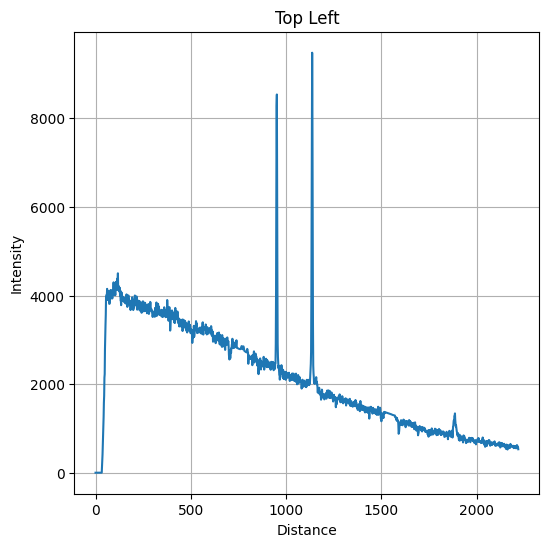

The maximum value in the top-right intensities array is: 11051


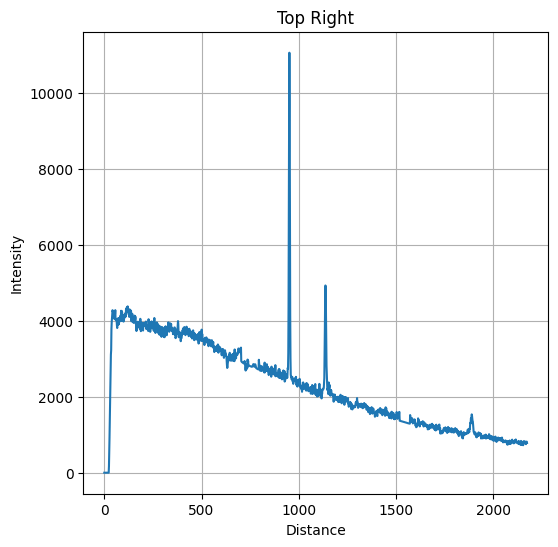

The maximum value in the bottom-left intensities array is: 10184


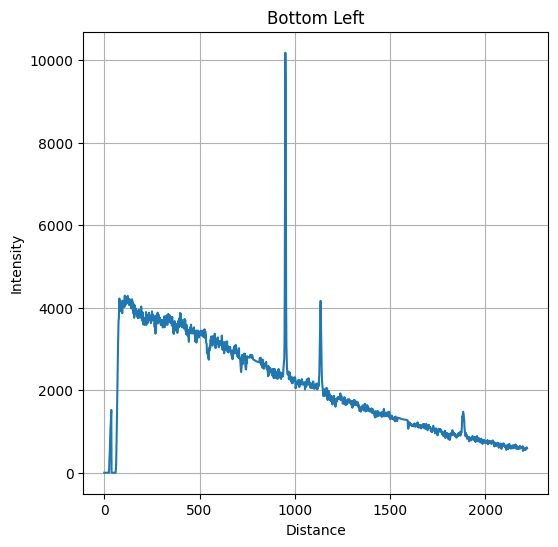

The maximum value in the bottom-right intensities array is: 57835


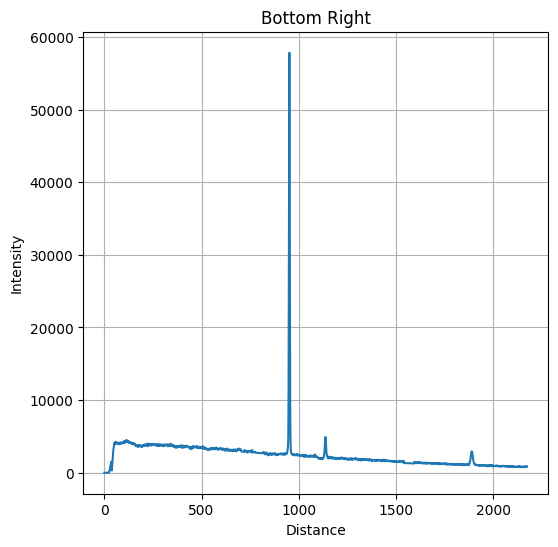

The maximum value in the center to top intensities array is: 13600


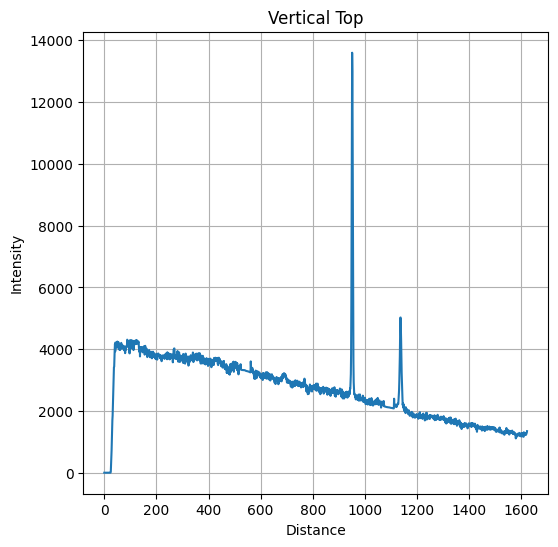

The maximum value in the center to bottom intensities array is: 9984


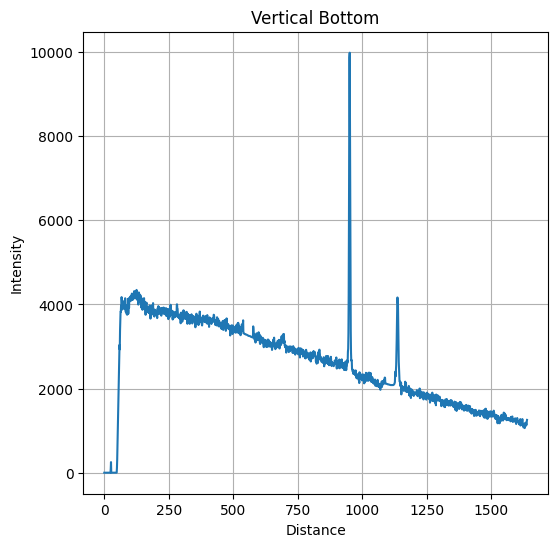

The maximum value in the middle-top-left intensities array is: 6007


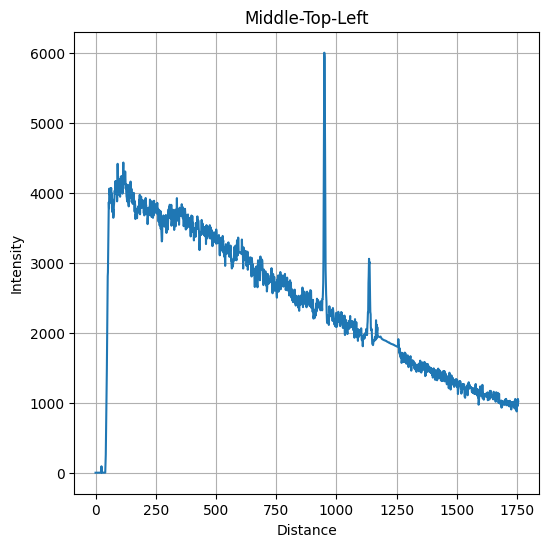

The maximum value in the middle-top-right intensities array is: 25132


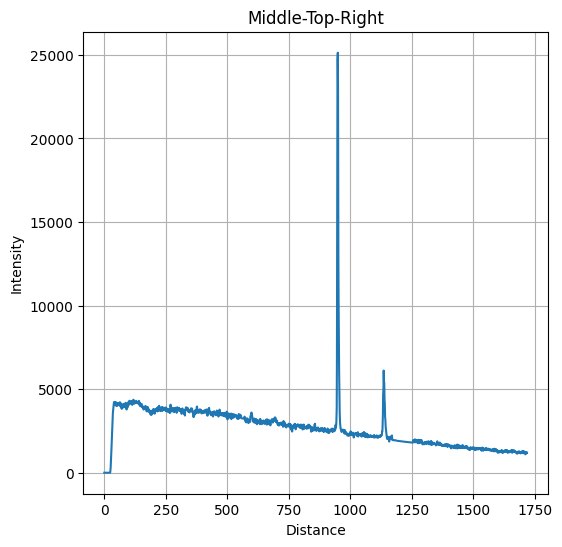

The maximum value in the middle-bottom-left intensities array is: 181522


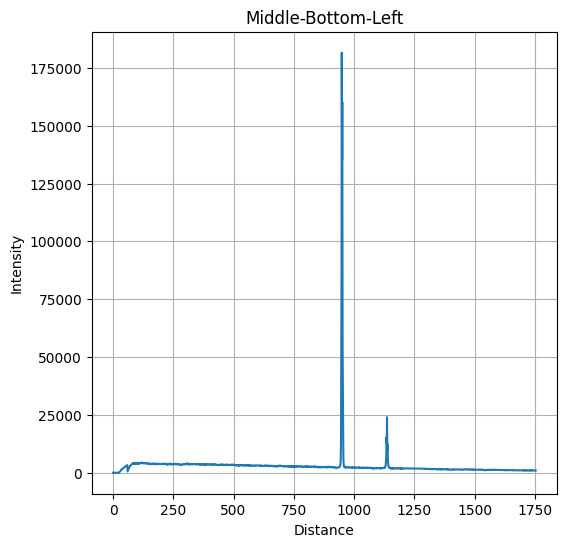

The maximum value in the middle-bottom-right intensities array is: 12214


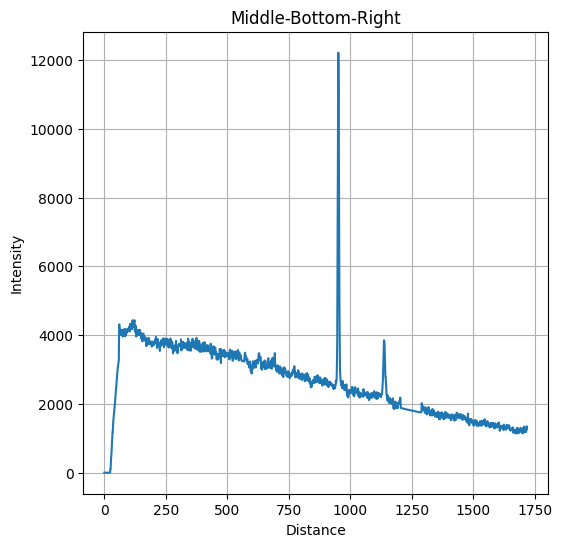

Streaming output truncated to the last 5000 lines.
Distance: 184.25, Average Intensity: 3810.5
Distance: 184.70, Average Intensity: 3696.5
Distance: 185.00, Average Intensity: 3849.0
Distance: 185.26, Average Intensity: 3868.25
Distance: 185.59, Average Intensity: 3759.5
Distance: 186.00, Average Intensity: 3800.0
Distance: 186.49, Average Intensity: 3801.0
Distance: 186.68, Average Intensity: 3773.5
Distance: 186.94, Average Intensity: 3725.5
Distance: 187.00, Average Intensity: 3885.0
Distance: 187.83, Average Intensity: 3728.5
Distance: 188.00, Average Intensity: 3833.0
Distance: 188.09, Average Intensity: 3753.25
Distance: 188.72, Average Intensity: 3832.0
Distance: 189.00, Average Intensity: 3890.0
Distance: 189.17, Average Intensity: 3749.0
Distance: 189.50, Average Intensity: 3802.75
Distance: 190.00, Average Intensity: 3749.5
Distance: 190.07, Average Intensity: 3711.25
Distance: 190.92, Average Intensity: 3782.0
Distance: 190.96, Average Intensity: 3812.5
Distance: 191.00, Ave

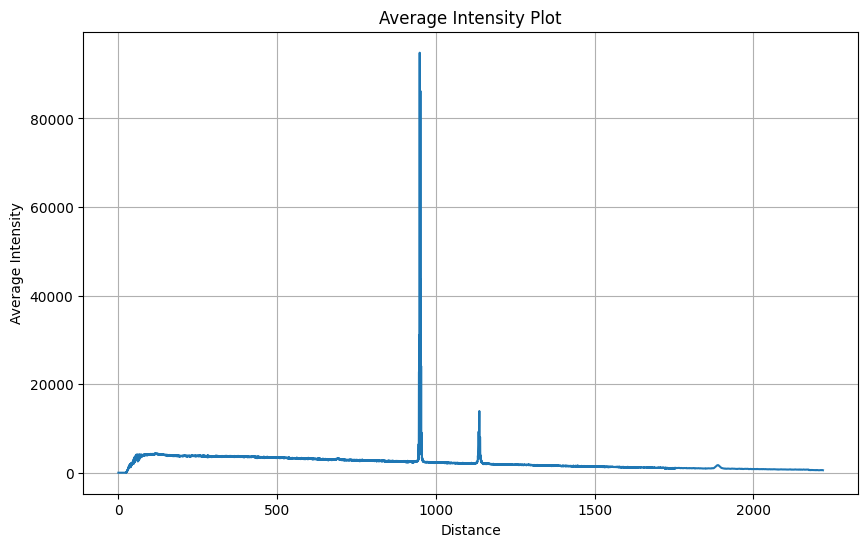

In [ ]:
#center_x, center_y = find_center(correct_image_data.shape)
height, width = correct_image_data.shape
center_x, center_y = find_center((width, height))
print(f'center_x: {center_x}, center_y: {center_y}')
plot_combined_diagonal_intensity(correct_image_data, center_x, center_y, 'Average Intensity Plot')

center_X: 1570, center_Y: 1623
center_x: 1570, center_y: 1623
The maximum value in the top-left intensities array is: 9481


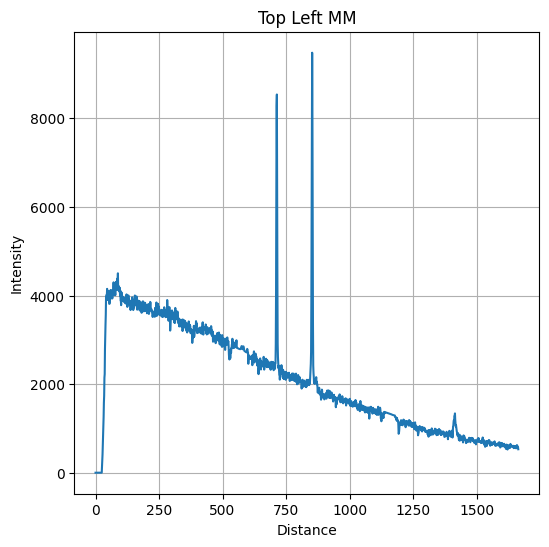

The maximum value in the top-right intensities array is: 11051


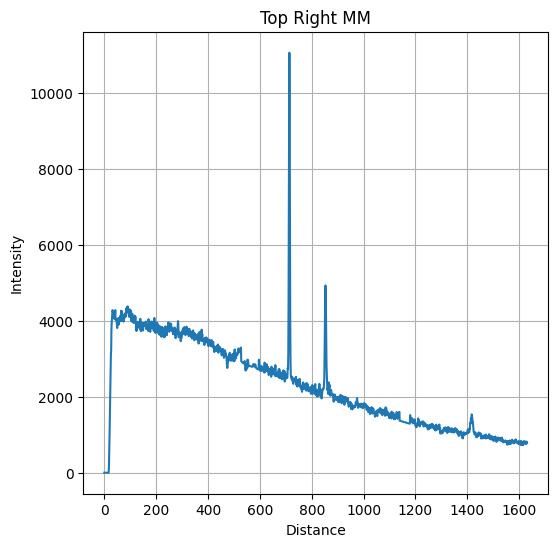

The maximum value in the bottom-left intensities array is: 10184


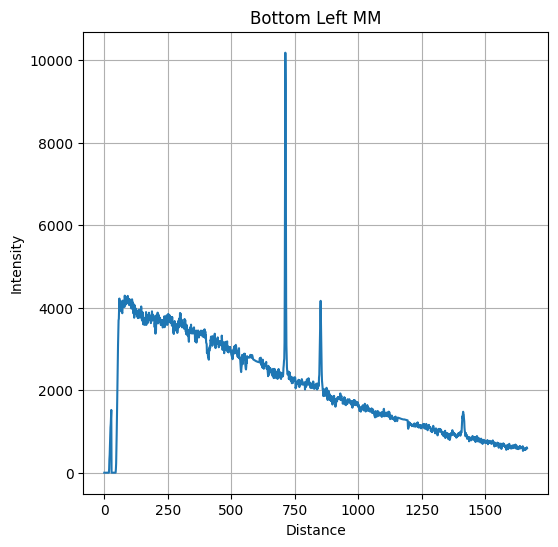

The maximum value in the bottom-right intensities array is: 57835


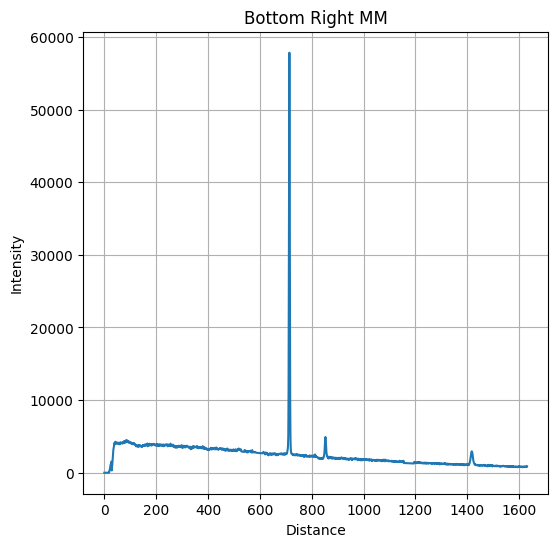

The maximum value in the center to top intensities array is: 13600


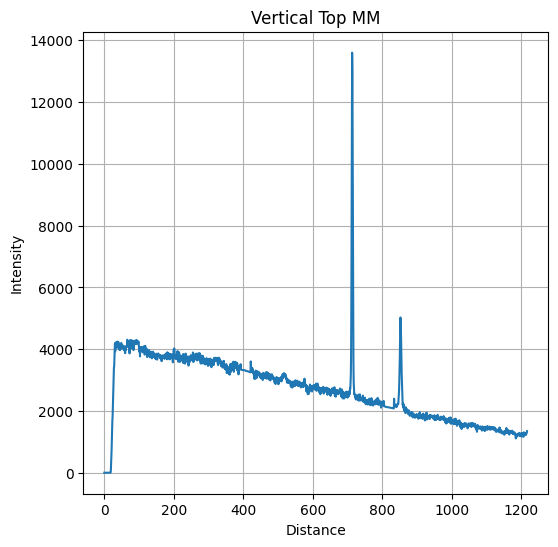

The maximum value in the center to bottom intensities array is: 9984


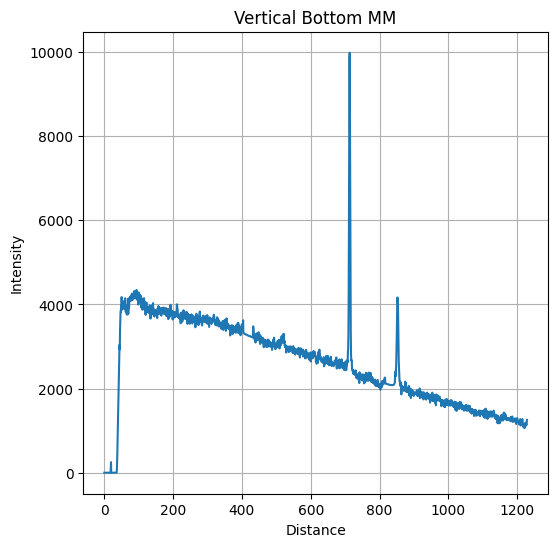

The maximum value in the middle-top-left intensities array is: 6007


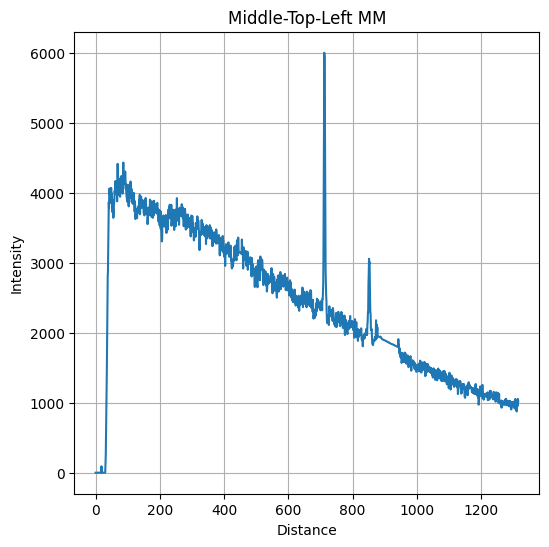

The maximum value in the middle-top-right intensities array is: 25132


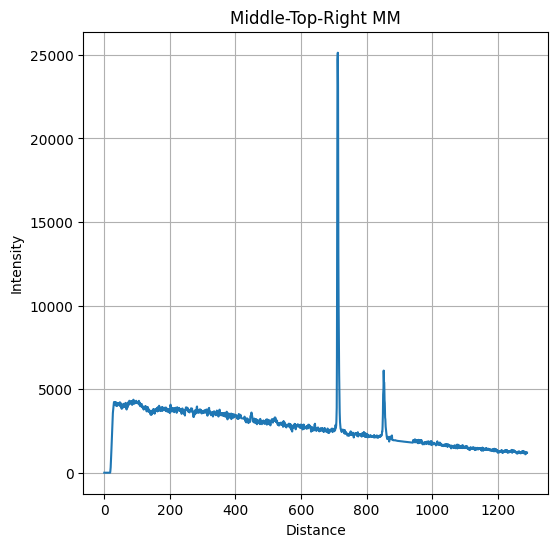

The maximum value in the middle-bottom-left intensities array is: 181522


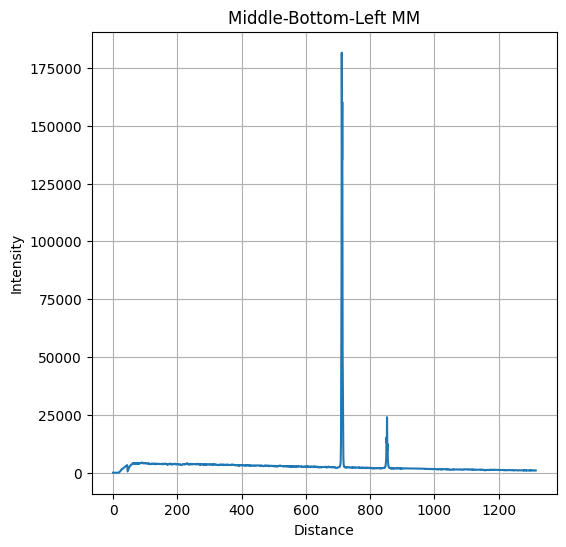

The maximum value in the middle-bottom-right intensities array is: 12214


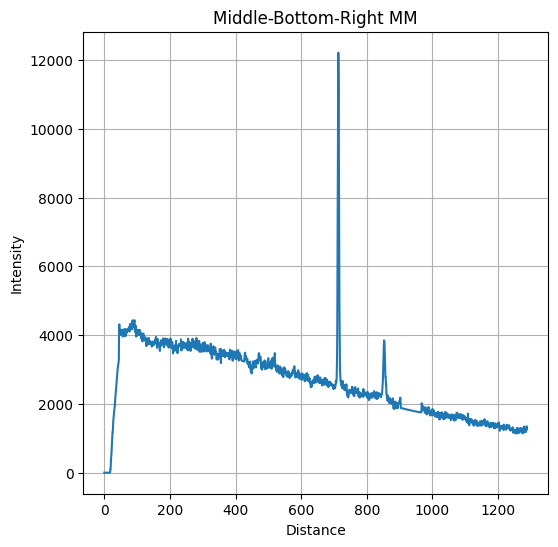

Streaming output truncated to the last 5000 lines.
Distance MM: 138.19, Average Intensity: 3810.5
Distance MM: 138.52, Average Intensity: 3696.5
Distance MM: 138.75, Average Intensity: 3849.0
Distance MM: 138.95, Average Intensity: 3868.25
Distance MM: 139.20, Average Intensity: 3759.5
Distance MM: 139.50, Average Intensity: 3800.0
Distance MM: 139.87, Average Intensity: 3801.0
Distance MM: 140.01, Average Intensity: 3773.5
Distance MM: 140.20, Average Intensity: 3725.5
Distance MM: 140.25, Average Intensity: 3885.0
Distance MM: 140.87, Average Intensity: 3728.5
Distance MM: 141.00, Average Intensity: 3833.0
Distance MM: 141.07, Average Intensity: 3753.25
Distance MM: 141.54, Average Intensity: 3832.0
Distance MM: 141.75, Average Intensity: 3890.0
Distance MM: 141.88, Average Intensity: 3749.0
Distance MM: 142.13, Average Intensity: 3802.75
Distance MM: 142.50, Average Intensity: 3749.5
Distance MM: 142.55, Average Intensity: 3711.25
Distance MM: 143.19, Average Intensity: 3782.0
Dista

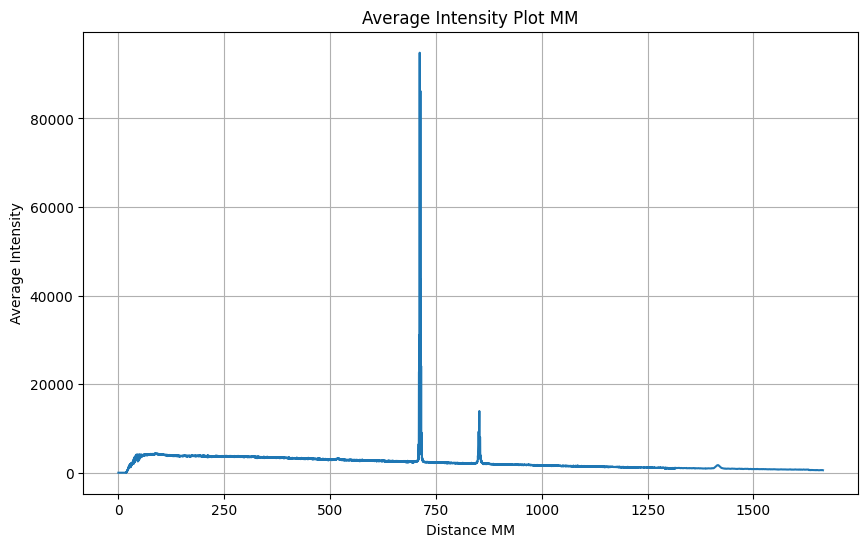

In [ ]:
#center_x, center_y = find_center(correct_image_data.shape)
height, width = correct_image_data.shape
center_x, center_y = find_center((width, height))
print(f'center_x: {center_x}, center_y: {center_y}')
plot_combined_diagonal_intensity_mm(correct_image_data, center_x, center_y, 'Average Intensity Plot MM')

center_X: 1570, center_Y: 1623
center_x: 1570, center_y: 1623
The maximum value in the top-left intensities array is: 9481


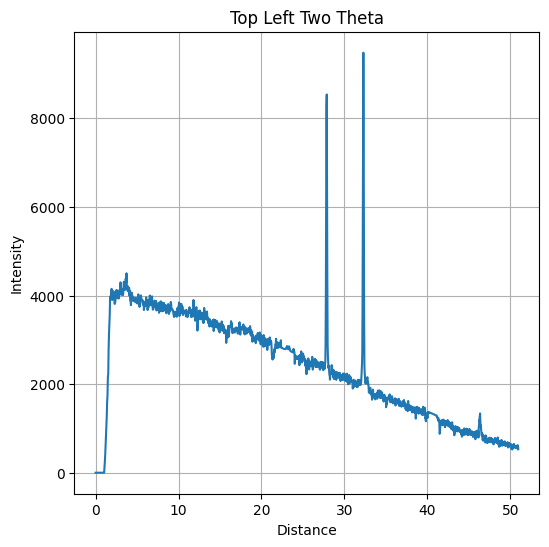

The maximum value in the top-right intensities array is: 11051


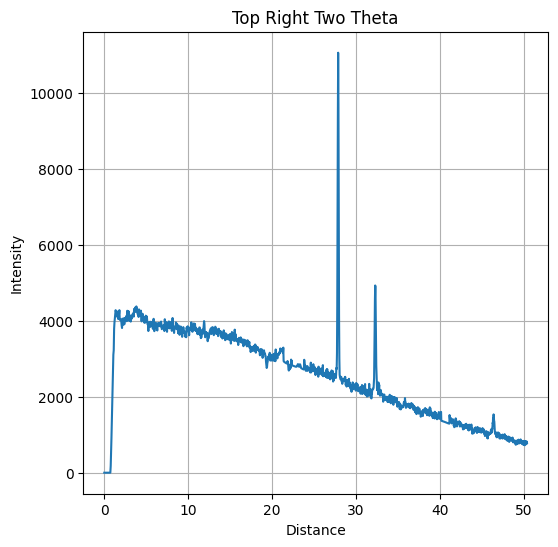

The maximum value in the bottom-left intensities array is: 10184


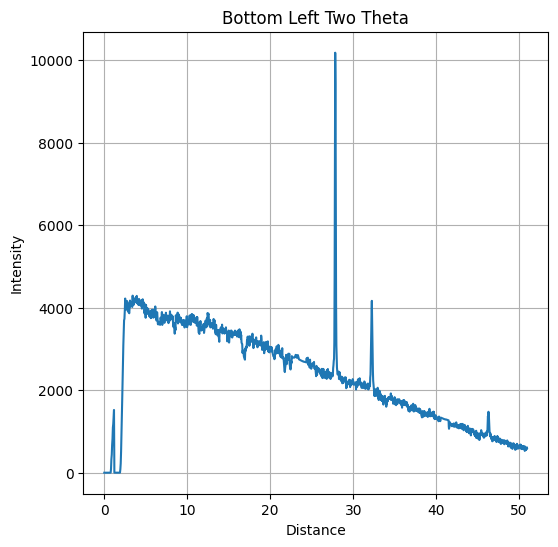

The maximum value in the bottom_right intensities array is: 57835


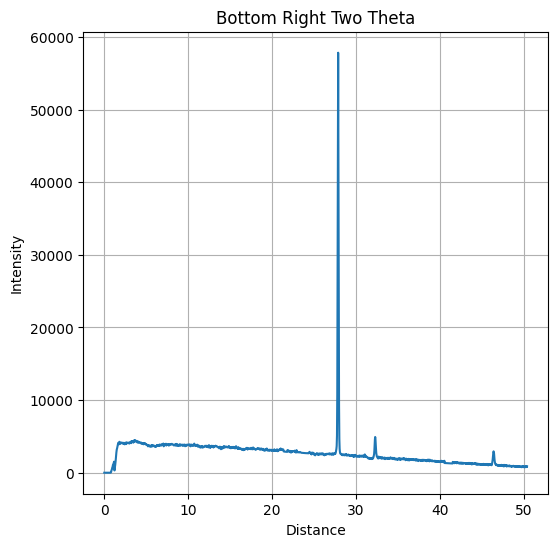

The maximum value in the center to top intensities array is: 13600


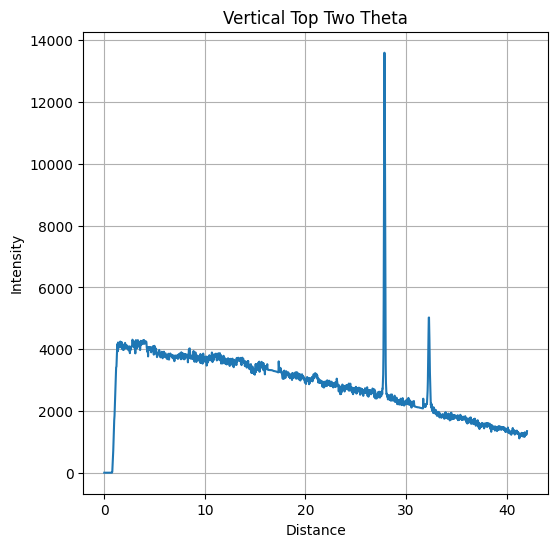

The maximum value in the center to bottom intensities array is: 9984


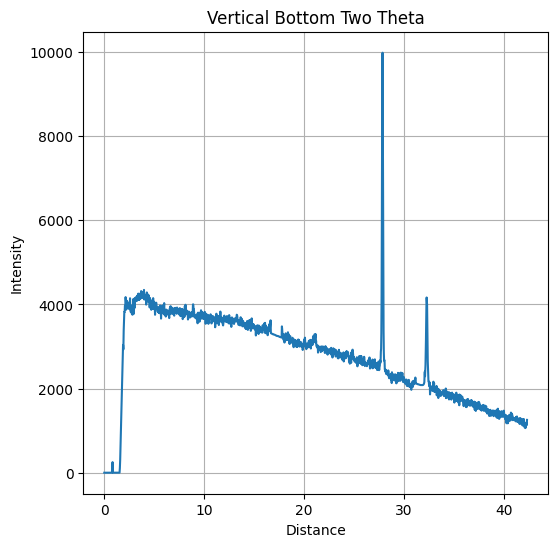

The maximum value in the middle-top-left intensities array is: 6007


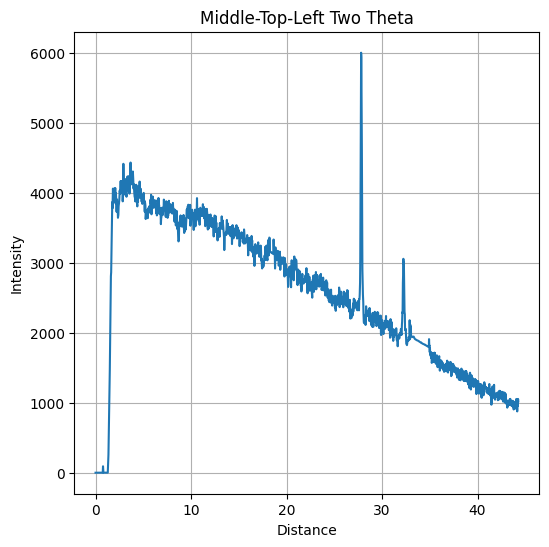

The maximum value in the middle-top-right intensities array is: 25132


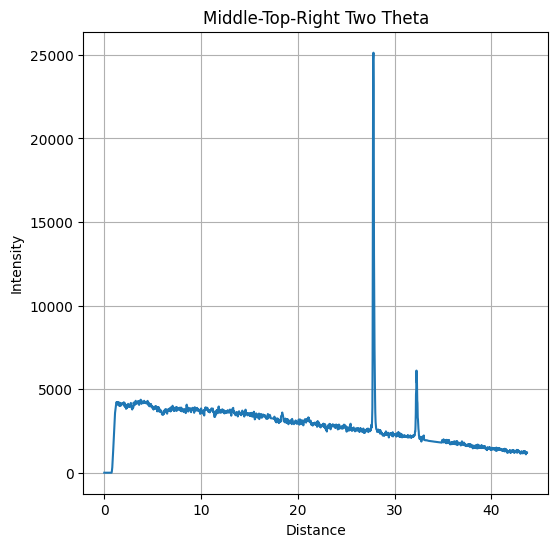

The maximum value in the middle-bottom-left intensities array is: 181522


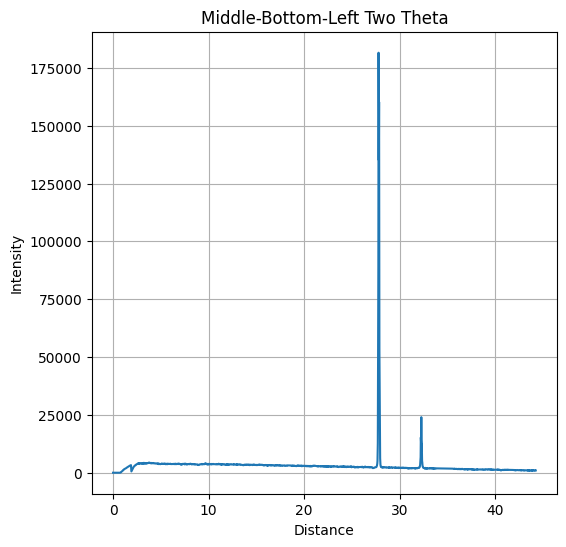

The maximum value in the middle-bottom-rigght intensities array is: 12214


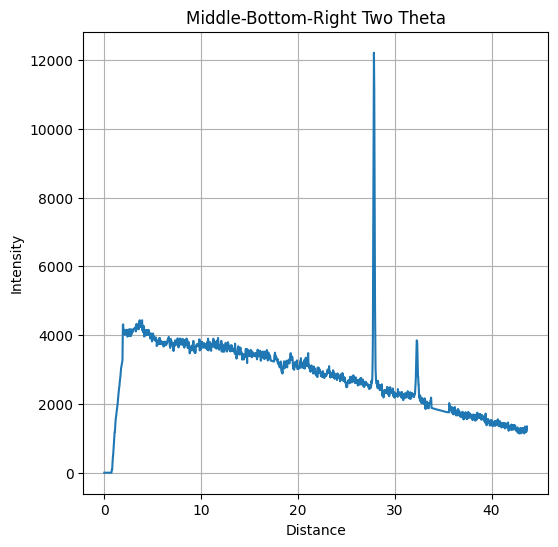

Streaming output truncated to the last 5000 lines.
Distance TwoTheta: 5.84, Average Intensity: 3810.5
Distance TwoTheta: 5.86, Average Intensity: 3696.5
Distance TwoTheta: 5.87, Average Intensity: 3849.0
Distance TwoTheta: 5.88, Average Intensity: 3868.25
Distance TwoTheta: 5.89, Average Intensity: 3759.5
Distance TwoTheta: 5.90, Average Intensity: 3800.0
Distance TwoTheta: 5.92, Average Intensity: 3801.0
Distance TwoTheta: 5.92, Average Intensity: 3773.5
Distance TwoTheta: 5.93, Average Intensity: 3725.5
Distance TwoTheta: 5.93, Average Intensity: 3885.0
Distance TwoTheta: 5.96, Average Intensity: 3728.5
Distance TwoTheta: 5.96, Average Intensity: 3833.0
Distance TwoTheta: 5.97, Average Intensity: 3753.25
Distance TwoTheta: 5.99, Average Intensity: 3832.0
Distance TwoTheta: 5.99, Average Intensity: 3890.0
Distance TwoTheta: 6.00, Average Intensity: 3749.0
Distance TwoTheta: 6.01, Average Intensity: 3802.75
Distance TwoTheta: 6.03, Average Intensity: 3749.5
Distance TwoTheta: 6.03, Ave

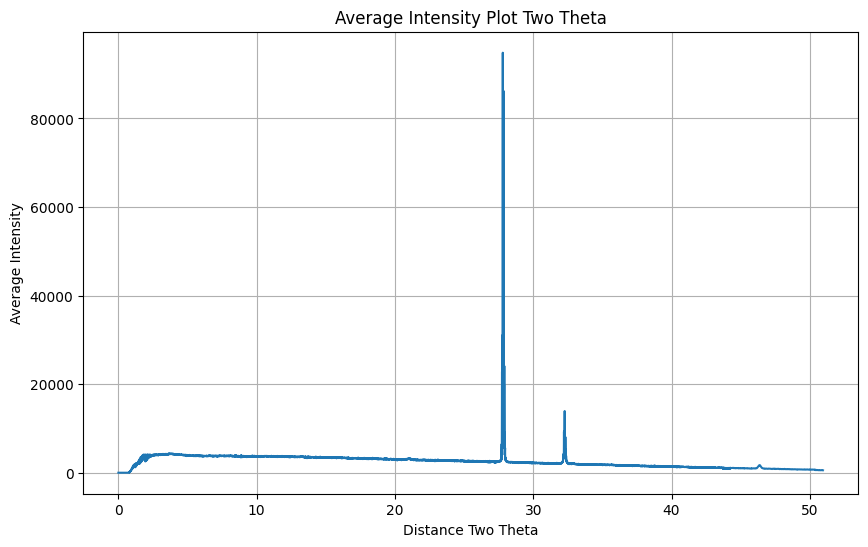

In [ ]:
height, width = correct_image_data.shape
center_x, center_y = find_center((width, height))
print(f'center_x: {center_x}, center_y: {center_y}')
plot_combined_diagonal_intensity_twotheta(correct_image_data, center_x, center_y, 'Average Intensity Plot Two Theta', False)

center_X: 1570, center_Y: 1623
center_x: 1570, center_y: 1623
The maximum value in the top-left intensities array is: 9481


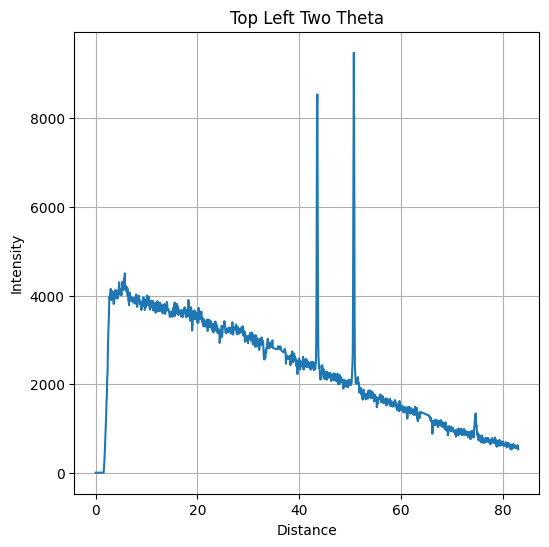

The maximum value in the top-right intensities array is: 11051


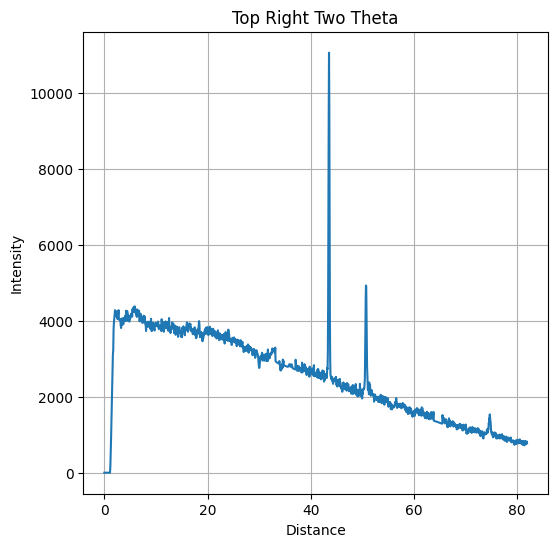

The maximum value in the bottom-left intensities array is: 10184


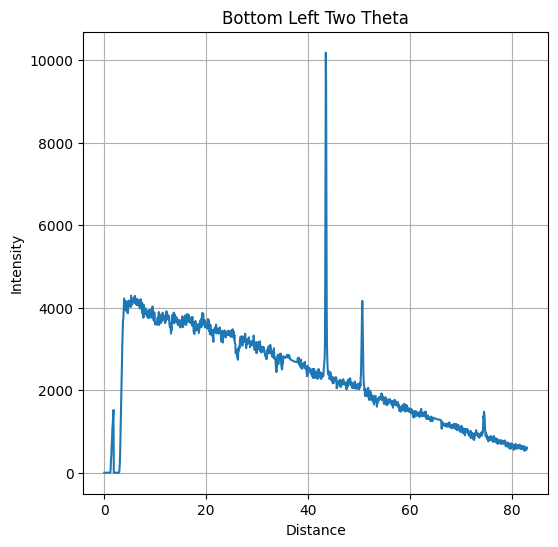

The maximum value in the bottom_right intensities array is: 57835


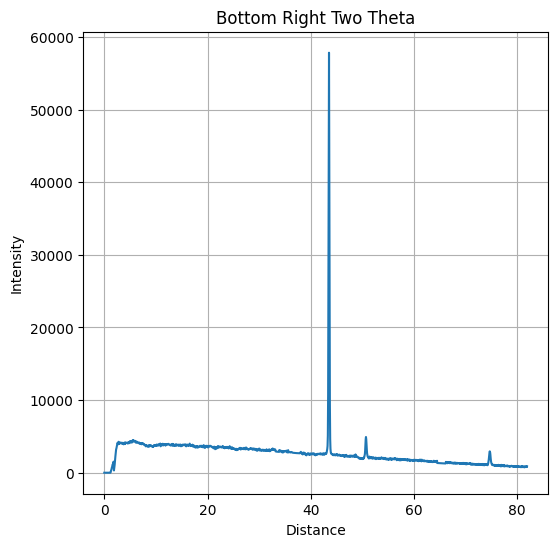

The maximum value in the center to top intensities array is: 13600


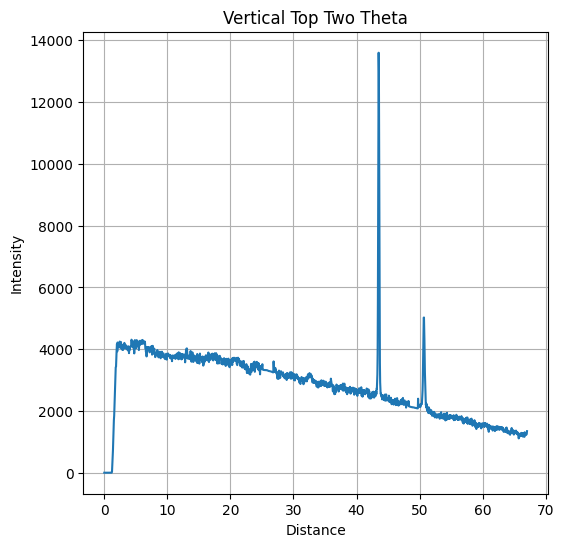

The maximum value in the center to bottom intensities array is: 9984


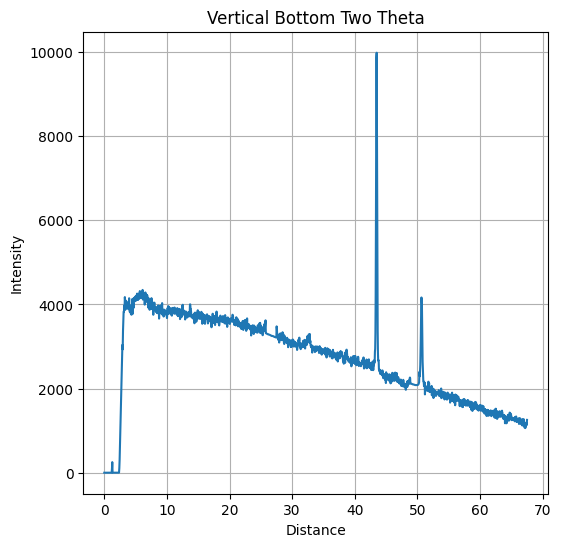

The maximum value in the middle-top-left intensities array is: 6007


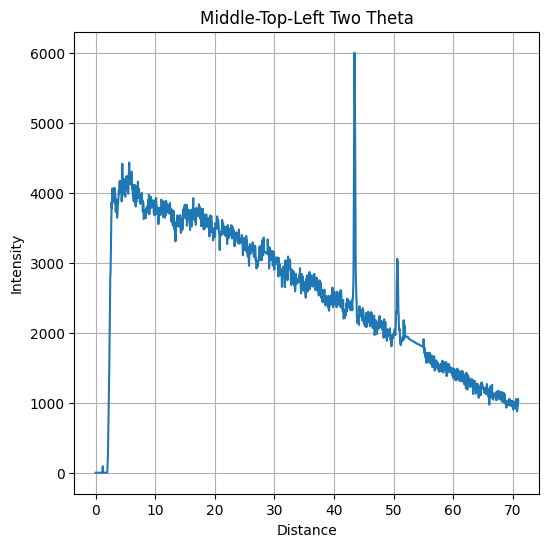

The maximum value in the middle-top-right intensities array is: 25132


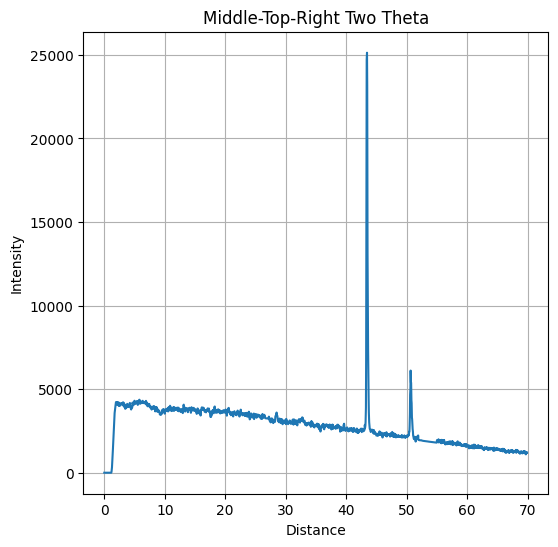

The maximum value in the middle-bottom-left intensities array is: 181522


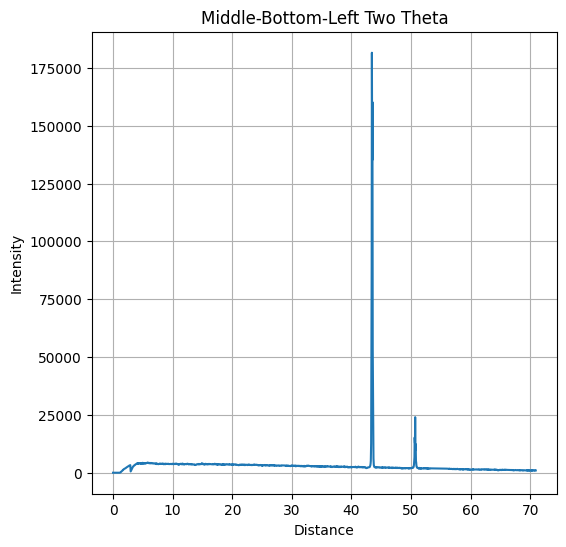

The maximum value in the middle-bottom-rigght intensities array is: 12214


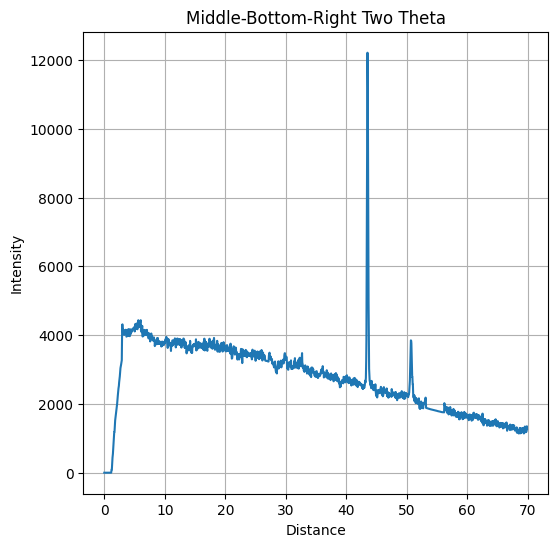

Streaming output truncated to the last 5000 lines.
Distance TwoTheta: 9.01, Average Intensity: 3810.5
Distance TwoTheta: 9.03, Average Intensity: 3696.5
Distance TwoTheta: 9.04, Average Intensity: 3849.0
Distance TwoTheta: 9.06, Average Intensity: 3868.25
Distance TwoTheta: 9.07, Average Intensity: 3759.5
Distance TwoTheta: 9.09, Average Intensity: 3800.0
Distance TwoTheta: 9.11, Average Intensity: 3801.0
Distance TwoTheta: 9.12, Average Intensity: 3773.5
Distance TwoTheta: 9.14, Average Intensity: 3725.5
Distance TwoTheta: 9.14, Average Intensity: 3885.0
Distance TwoTheta: 9.18, Average Intensity: 3728.5
Distance TwoTheta: 9.19, Average Intensity: 3833.0
Distance TwoTheta: 9.19, Average Intensity: 3753.25
Distance TwoTheta: 9.22, Average Intensity: 3832.0
Distance TwoTheta: 9.24, Average Intensity: 3890.0
Distance TwoTheta: 9.25, Average Intensity: 3749.0
Distance TwoTheta: 9.26, Average Intensity: 3802.75
Distance TwoTheta: 9.29, Average Intensity: 3749.5
Distance TwoTheta: 9.29, Ave

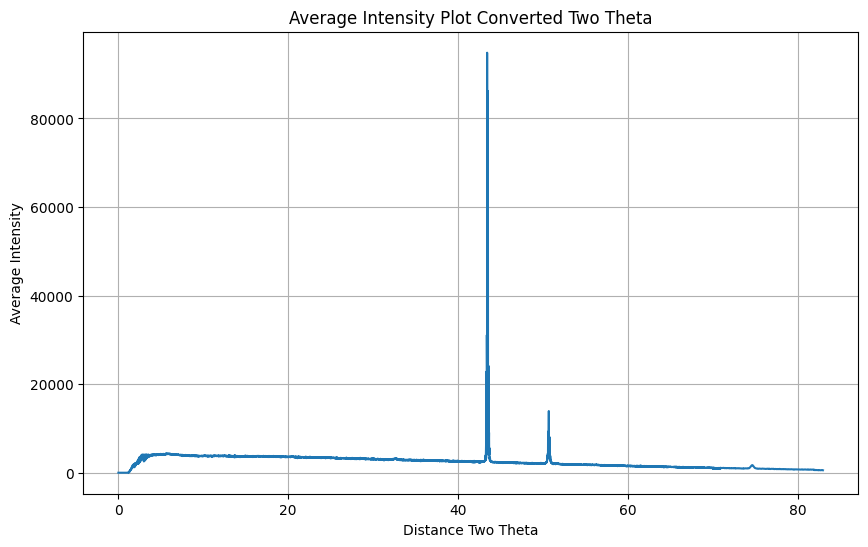

In [ ]:
height, width = correct_image_data.shape
center_x, center_y = find_center((width, height))
print(f'center_x: {center_x}, center_y: {center_y}')
plot_combined_diagonal_intensity_twotheta(correct_image_data, center_x, center_y, 'Average Intensity Plot Converted Two Theta', True)

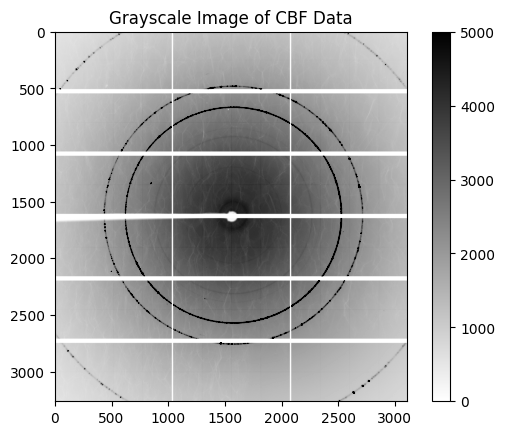

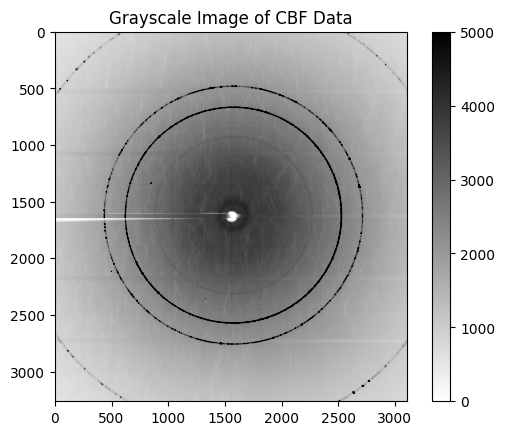

In [ ]:
plot_grayscale_image(main_image_data)
plot_grayscale_image(correct_image_data)

center_X: 1570, center_Y: 1623
results size: 10138296
max_distance size: 1690

Sum of intensities array with distances in MM:
Distance: 0, Intensity: -1.00e+00
Distance: 1, Intensity: -8.00e+00
Distance: 2, Intensity: -2.80e+01
Distance: 3, Intensity: -3.20e+01
Distance: 4, Intensity: -4.40e+01
Distance: 5, Intensity: -6.40e+01
Distance: 6, Intensity: -6.40e+01
Distance: 7, Intensity: -6.40e+01
Distance: 8, Intensity: -1.00e+02
Distance: 9, Intensity: -1.60e+01
Distance: 10, Intensity: 0.00e+00
Distance: 11, Intensity: 0.00e+00
Distance: 12, Intensity: 0.00e+00
Distance: 13, Intensity: 0.00e+00
Distance: 14, Intensity: 0.00e+00
Distance: 15, Intensity: 0.00e+00
Distance: 16, Intensity: 0.00e+00
Distance: 17, Intensity: 4.03e+02
Distance: 18, Intensity: 5.62e+03
Distance: 19, Intensity: 3.46e+04
Distance: 20, Intensity: 8.35e+04
Distance: 21, Intensity: 1.14e+05
Distance: 22, Intensity: 1.46e+05
Distance: 23, Intensity: 2.20e+05
Distance: 24, Intensity: 2.65e+05
Distance: 25, Intensity:

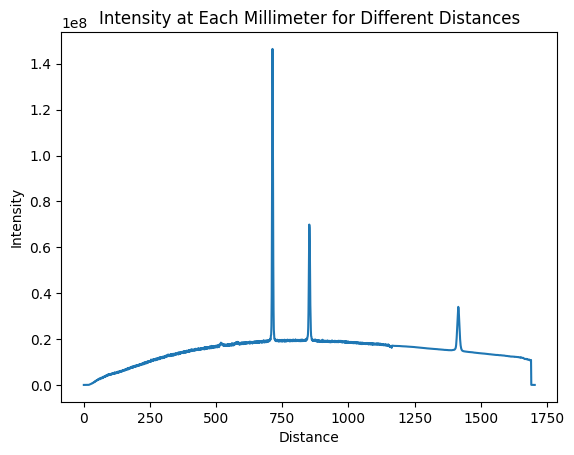

In [ ]:
# Calculate distances and intensities
results = calculate_distance_and_intensity(correct_image_data, dim_x, dim_y)

sumOfIntensity = calculate_sum_of_intensity(results, dim_x, dim_y)
print("\nSum of intensities array with distances in MM:")
for index, value in enumerate(sumOfIntensity):
  print(f"Distance: {index}, Intensity: {value:.2e}")

# Plot intensity values at each pixel for different distances
plot_intensity_values(sumOfIntensity, "Intensity at Each Millimeter for Different Distances")

# Sort the dictionary by keys (distances) and extract values (intensities)
# distances = sorted(sumOfIntensity.keys())
# intensities = sorted([sumOfIntensity[dist] for dist in distances])

# Apply baseline correction using an appropriate method from pybaselines
# baseline = modpoly(intensities, polynomial_degree=2)[0]

# Subtract the baseline from the original intensities
# corrected_intensities = intensities - baseline

# plt.figure(figsize=(10, 6))
# plt.plot(distances, corrected_intensities)
# plt.title(title)
# plt.xlabel('Distance')
# plt.ylabel('Average Intensity')
# plt.grid(True)
# plt.show()

# Plotting the original and processed signals
#plot_intensity_values(corrected_y, "After Baseline Subtraction")
#plot_intensity_values(smooth_y, "After Smoothing")




Sum of intensities array with distances in two theta:
Two theta distance: 51.45, Intensity: 18444
Two theta distance: 51.43, Intensity: 21780
Two theta distance: 51.41, Intensity: 22960
Two theta distance: 51.40, Intensity: 28613
Two theta distance: 51.38, Intensity: 33427
Two theta distance: 51.37, Intensity: 38496
Two theta distance: 51.35, Intensity: 42829
Two theta distance: 51.33, Intensity: 46759
Two theta distance: 51.32, Intensity: 51702
Two theta distance: 51.30, Intensity: 51345
Two theta distance: 51.28, Intensity: 59778
Two theta distance: 51.27, Intensity: 66869
Two theta distance: 51.25, Intensity: 74578
Two theta distance: 51.23, Intensity: 80330
Two theta distance: 51.22, Intensity: 88513
Two theta distance: 51.20, Intensity: 97421
Two theta distance: 51.18, Intensity: 98952
Two theta distance: 51.17, Intensity: 105136
Two theta distance: 51.15, Intensity: 112811
Two theta distance: 51.13, Intensity: 125656
Two theta distance: 51.12, Intensity: 136230
Two theta distanc

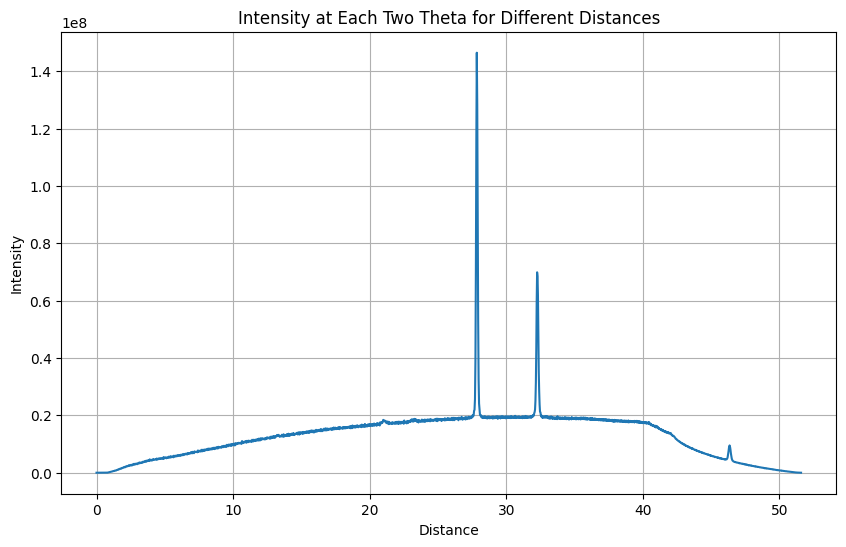

In [ ]:
sumOfIntensitytwotheta = calculate_sum_of_intensity_with_twotheta_distances(results, dim_x, dim_y, False)
print("\nSum of intensities array with distances in two theta:")
#for index, value in enumerate(sumOfIntensitytwotheta):
for dist in sumOfIntensitytwotheta:
   print(f"Two theta distance: {dist:.2f}, Intensity: {sumOfIntensitytwotheta[dist]}")

# Plot intensity values at each pixel for different distances
sorted_distances = sorted(sumOfIntensitytwotheta.keys())
sorted_intensities = [sumOfIntensitytwotheta[dist] for dist in sorted_distances]

# Plot combined intensity
plt.figure(figsize=(10, 6))
plt.plot(sorted_distances, sorted_intensities)
plt.title('Intensity at Each Two Theta for Different Distances')
plt.xlabel('Distance')
plt.ylabel('Intensity')
plt.grid(True)
plt.show()

# plot_intensity_values(sumOfIntensitytwotheta, "Intensity at Each Two Theta for Different Distances")


Sum of intensities array with distances in converted two theta:
Converted two theta distance: 83.89, Intensity: 18444
Converted two theta distance: 83.86, Intensity: 21780
Converted two theta distance: 83.83, Intensity: 22960
Converted two theta distance: 83.80, Intensity: 28613
Converted two theta distance: 83.77, Intensity: 33427
Converted two theta distance: 83.74, Intensity: 38496
Converted two theta distance: 83.70, Intensity: 42829
Converted two theta distance: 83.67, Intensity: 46759
Converted two theta distance: 83.64, Intensity: 51702
Converted two theta distance: 83.61, Intensity: 51345
Converted two theta distance: 83.58, Intensity: 59778
Converted two theta distance: 83.55, Intensity: 66869
Converted two theta distance: 83.52, Intensity: 74578
Converted two theta distance: 83.49, Intensity: 80330
Converted two theta distance: 83.46, Intensity: 88513
Converted two theta distance: 83.43, Intensity: 97421
Converted two theta distance: 83.39, Intensity: 98952
Converted two the

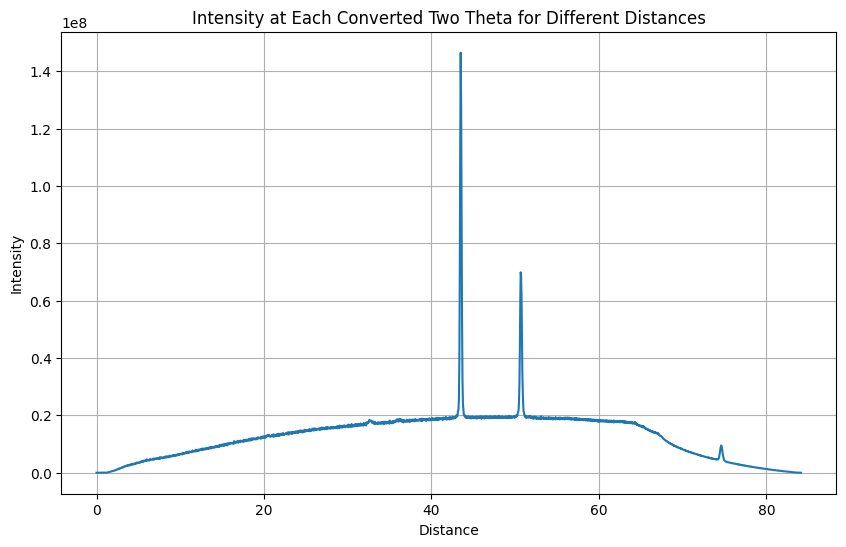

In [ ]:
sumOfIntensitytwotheta = calculate_sum_of_intensity_with_twotheta_distances(results, dim_x, dim_y, True)
print("\nSum of intensities array with distances in converted two theta:")
#for index, value in enumerate(sumOfIntensitytwotheta):
for dist in sumOfIntensitytwotheta:
   print(f"Converted two theta distance: {dist:.2f}, Intensity: {sumOfIntensitytwotheta[dist]}")

# Plot intensity values at each pixel for different distances
sorted_distances = sorted(sumOfIntensitytwotheta.keys())
sorted_intensities = [sumOfIntensitytwotheta[dist] for dist in sorted_distances]

# Plot combined intensity
plt.figure(figsize=(10, 6))
plt.plot(sorted_distances, sorted_intensities)
plt.title('Intensity at Each Converted Two Theta for Different Distances')
plt.xlabel('Distance')
plt.ylabel('Intensity')
plt.grid(True)
plt.show()